## Accurate variant calling and genotyping in polyploids 

This notebook contains all the commands required to reproduce all of the results presented in the paper Cooke et al. (2020). All of the data can be downloaded from public sources, although some have protected access and require login. The script does not check software versions so you'll need to manually check you are using all of the right tool versions if trying to reproduce the paper results exactly. I'm not checking or updating any of the data hard-coded links so please submit issues or pull requests if any stop working.

Most of the commands can be executed locally or submitted to a cluster via qsub.

In [1]:
%matplotlib notebook

In [488]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import subprocess as sp
import gzip
import pysam as ps
import os
import time
import shutil
import wget
import requests
import zipfile
import io
import multiprocessing
import random
import csv
import upsetplot as usp
from pathlib import Path
from matplotlib.ticker import FormatStrFormatter

In [609]:
# All of these variables need to be defined to run the experiments

# Utility programs
tool_dir = Path("bin")
rtg_bin = tool_dir / "rtg-tools/rtg"
bcftools_bin = tool_dir / "bcftools"
bedtools_bin = tool_dir / "bedtools"
samtools_bin = tool_dir / "samtools"
bwa_bin = tool_dir / "bwa"
seqtk_bin = tool_dir / "seqtk"
bedops_bin = tool_dir / "bedops"
time_bin = tool_dir / "time"
parallel_bin = tool_dir / "parallel"
sratools_dir = tool_dir / "sratools"
pbmm2_bin = tool_dir / "pbmm2"
starfish_bin = tool_dir / "starfish.py"

# Variant callers
octopus_dir = tool_dir / "octopus"
gatk_bin = tool_dir / "gatk"
freebayes_dir = tool_dir / "freebayes"
octopus_bin = octopus_dir / "bin" / "octopus"
#octopus_forest = octopus_dir / "resources" / "forests" / "polyploid.forest"
octopus_forest = None
use_gatk_spark = False # Spark still in Beta and crashes in 4.1.8.1

caller_score_metric = {
    "GATK4": "GQ",
    "FreeBayes": "GQ",
    "Octopus": "GQ"
}

# queue config
qsub_project = "lunter.prjc"
qsub_long_queue = "long.qf"
qsub_short_queue = "short.qf"
qsub_gb_per_core = 4

# Experiment directories and files
data_dir = Path("data")
results_dir = Path("results")
reference_dir = data_dir / "references"
fastq_dir = data_dir / "fastq"
bam_dir = data_dir / "bam"
truth_dir = data_dir / "truth"
vcf_dir = results_dir / "vcf"
vcfeval_dir = results_dir / "eval"
figure_dir = results_dir / "figures"
tables_dir = results_dir / "tables"

references = {
    "hs38DH": reference_dir / "hs38DH.fa",
    "GRCh38": reference_dir / "GRCh38_no_alt_plus_hs38d1_analysis_set.fa",
    "musa_acuminata": reference_dir / "musa_acuminata.fa",
    "solanum_tuberosum": reference_dir / "solanum_tuberosum.fa"
}

reference_regions = {
    "hs38DH": {
        "autosomes": reference_dir / "hs38DH.autosomes.bed",
        "chromosomes": reference_dir / "hs38DH.chromosomes.bed"
    },
    "GRCh38": {
        "autosomes": reference_dir / "GRCh38.autosomes.bed",
        "chromosomes": reference_dir / "GRCh38.chromosomes.bed"
    },
    "musa_acuminata": {
        "chromosomes": reference_dir / "musa_acuminata.chromosomes.bed"
    },
    "solanum_tuberosum": {
        "chromosomes": reference_dir / "solanum_tuberosum.chromosomes.bed"
    },
}

reference_ploidies = {
    "hs38DH": 2,
    "GRCh38": 2,
    "musa_acuminata": 3,
    "solanum_tuberosum": 4
}

data_info = {
    "NovaSeq": {
        "HG002": {
            "depth": 35
        },
        "HG003": {
            "depth": 35
        },
        "HG004": {
            "depth": 35
        },
    },
    "PacBioHiFi": {
        "HG002": {
            "depth": 35
        },
        "HG003": {
            "depth": 35
        },
        "HG004": {
            "depth": 35
        },
    },
    "HiSeq-1500": {
        "banana": {
            "depth": 55
        }
    },
    "NextSeq-500": {
        "banana": {
            "depth": 65
        }
    },
    "HiSeq": {
        "potato": {
            "depth": 40
        }
    }
}

fastqs = {
    "NovaSeq": {
        "HG002": (
            fastq_dir / "HG002.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG002.novaseq.pcr-free.35x.R2.fastq.gz"
        ),
        "HG003": (
            fastq_dir / "HG003.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG003.novaseq.pcr-free.35x.R2.fastq.gz"
        ),
        "HG004": (
            fastq_dir / "HG004.novaseq.pcr-free.35x.R1.fastq.gz",
            fastq_dir / "HG004.novaseq.pcr-free.35x.R2.fastq.gz"
        )
    },
    "PacBioHiFi": {
        "HG002": (
            fastq_dir / "HG002_35x_PacBio_14kb-15kb.fastq.gz"
        ),
        "HG003": (
            fastq_dir / "HG003_35x_PacBio_14kb-15kb.fastq.gz"
        ),
        "HG004": (
            fastq_dir / "HG004_35x_PacBio_14kb-15kb.fastq.gz"
        )
    },
    "HiSeq-1500": {
        "banana": (
            fastq_dir / "musa_acuminata.55x.R1.fastq.gz",
            fastq_dir / "musa_acuminata.55x.R2.fastq.gz"
        )
    },
    "NextSeq-500": {
        "banana": (
            fastq_dir / "musa_acuminata.65x.R1.fastq.gz",
            fastq_dir / "musa_acuminata.65x.R2.fastq.gz"
        )
    },
    "HiSeq": {
        "potato": (
            fastq_dir / "solanum_tuberosum.40x.R1.fastq.gz",
            fastq_dir / "solanum_tuberosum.40x.R2.fastq.gz",
        )
    }
}

truths = {
    "HG002": (
        truth_dir / "HG002_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG002_GRCh38_1_22_v4.2_benchmark.bed"
    ),
    "HG003": (
        truth_dir / "HG003_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG003_GRCh38_1_22_v4.2_benchmark.bed"
    ),
    "HG004": (
        truth_dir / "HG004_GRCh38_1_22_v4.2_benchmark.vcf.gz",
        truth_dir / "HG004_GRCh38_1_22_v4.2_benchmark.bed"
    )
}

In [4]:
# https://stackoverflow.com/a/9419208/2970186
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def download_ftp(link, save_path):
    wget.download(link, out=str(save_path))

In [5]:
if not references["musa_acuminata"].exists():
    banana_ref_url = "https://banana-genome-hub.southgreen.fr/sites/banana-genome-hub.southgreen.fr/files/data/fasta/version2/musa_acuminata_v2_pseudochromosome.fna"
    download_url(banana_ref_url, references["musa_acuminata"])
    sp.call([samtools_bin, "faidx", references["musa_acuminata"]])
    sp.call([bwa_bin, 'index', references["musa_acuminata"]])
    sp.call([gatk_bin, 'CreateSequenceDictionary', '-R', references["musa_acuminata"]])

if not references["solanum_tuberosum"].exists():
    potato_ref_url = "http://solanaceae.plantbiology.msu.edu/data/potato_dm_v404_all_pm_un.fasta.zip"
    r = requests.get(potato_ref_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    download_dir = references["solanum_tuberosum"].with_suffix(".tmp")
    z.extractall(download_dir)
    (download_dir / "potato_dm_v404_all_pm_un.fasta").rename(references["solanum_tuberosum"])
    download_dir.rmdir()
    sp.call([samtools_bin, "faidx", references["solanum_tuberosum"]])
    sp.call([bwa_bin, 'index', references["solanum_tuberosum"]])
    sp.call([gatk_bin, 'CreateSequenceDictionary', '-R', references["solanum_tuberosum"]])

In [6]:
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def create_bed_from_fasta_index(fasta_index_filename, bed_filename, condition):
    with fasta_index_filename.open() as fai:
        faireader = csv.reader(fai, delimiter='\t')
        with bed_filename.open('w') as bed:
            bedwriter = csv.writer(bed, delimiter='\t')
            for line in faireader:
                if represents_int(line[0]) or (line[0].startswith("chr") and represents_int(line[0][3:])):
                    bedwriter.writerow([line[0], 0, line[1]])

def is_numeric_chromosome(line):
    return represents_int(line[0]) or (line[0].startswith("chr") and represents_int(line[0][3:]))

def create_region_beds(reference):
    if not reference_regions[reference]["chromosomes"].exists():
        reference_index = references[reference].with_suffix(references[reference].suffix + '.fai')
        create_bed_from_fasta_index(reference_index, reference_regions[reference]["chromosomes"],
                                    lambda line: is_numeric_chromosome(line))

create_region_beds("musa_acuminata")
create_region_beds("solanum_tuberosum")

In [7]:
def cat_files(source_filenames, destination_filename):
    with destination_filename.open('wb') as destination:
        for source_filename in source_filenames:
            shutil.copyfileobj(source_filename.open('rb'), destination)

All of the banana reads we used, generated by Busche et al (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6945009/), are hosted on ENA (https://www.ebi.ac.uk/ena/browser/view/PRJEB33317)

In [225]:
if not fastqs["HiSeq-1500"]["banana"][1].exists():
    banana_hiseq_ena_run_accessions = [("ERR3412983", "003"), ("ERR3412984", "004")]
    tmp_fastqs = []
    for run_accession, d in banana_hiseq_ena_run_accessions:
        link_prefix = "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR341/" + d + "/" + run_accession + '/' + run_accession + "_"
        fq1, fq2 = fastq_dir / (run_accession + ".R1.fastq.gz"), fastq_dir / (run_accession + ".R2.fastq.gz")
        download_ftp(link_prefix + "1.fastq.gz", fq1)
        download_ftp(link_prefix + "2.fastq.gz", fq2)
        tmp_fastqs.append((fq1, fq2))
    cat_files([fq[0] for fq in tmp_fastqs], fastqs["HiSeq-1500"]["banana"][0])
    cat_files([fq[1] for fq in tmp_fastqs], fastqs["HiSeq-1500"]["banana"][1])
    for fq1, fq2 in tmp_fastqs:
        fq1.unlink()
        fq2.unlink()

if not fastqs["NextSeq-500"]["banana"][1].exists():
    banana_nextseq_ena_run_accessions = [("ERR3413471", "001"), ("ERR3413472", "002"), ("ERR3413473", "003"), ("ERR3413474", "004")]
    tmp_fastqs = []
    for run_accession, d in banana_nextseq_ena_run_accessions:
        link_prefix = "ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR341/" + d + "/" + run_accession + '/' + run_accession + "_"
        fq1, fq2 = fastq_dir / (run_accession + ".R1.fastq.gz"), fastq_dir / (run_accession + ".R2.fastq.gz")
        download_ftp(link_prefix + "1.fastq.gz", fq1)
        download_ftp(link_prefix + "2.fastq.gz", fq2)
        tmp_fastqs.append((fq1, fq2))
    cat_files([fq[0] for fq in tmp_fastqs], fastqs["NextSeq-500"]["banana"][0])
    cat_files([fq[1] for fq in tmp_fastqs], fastqs["NextSeq-500"]["banana"][1])
    for fq1, fq2 in tmp_fastqs:
        fq1.unlink()
        fq2.unlink()

The potato reads are hosted on SRA (https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR10248513) and need to be downloaded with SRA tools.

In [9]:
def get_coverage(library, sample):
    return data_info[library][sample]["depth"]

In [543]:
all_callers = ["Octopus", "GATK4", "FreeBayes"]

diploid_illumina_experiments = []
for depth in [10, 20, 30]:
    diploid_illumina_experiments.append(
        {
            "reference": "hs38DH",
            "samples": ["HG002"],
            "library": "NovaSeq",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes"
        }
    )

synthetic_tetraploid_illumina_experiments = []
for depth in range(10, 80, 10):
    synthetic_tetraploid_illumina_experiments.append(
        {
            "reference": "hs38DH",
            "samples": ["HG003", "HG004"],
            "library": "NovaSeq",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes",
            "caller_options": {
                "Octopus": {
                    "--max-genotypes": 20000,
                    "--disable-early-phase-detection": None
                }
            }
        }
    )
synthetic_tetraploid_pacbio_experiments = []
for depth in range(10, 80, 10):
    synthetic_tetraploid_pacbio_experiments.append(
        {
            "reference": "GRCh38",
            "samples": ["HG003", "HG004"],
            "library": "PacBioHiFi",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes",
            "caller_options": {
                "Octopus": {
                    "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config",
                    "--max-genotypes": 20000,
                    "--disable-early-phase-detection": None
                }
            }
        }
    )
synthetic_hexaploid_illumina_experiments = []
for depth in range(10, 110, 10):
    synthetic_hexaploid_illumina_experiments.append(
        {
            "reference": "hs38DH",
            "samples": ["HG002", "HG003", "HG004"],
            "library": "NovaSeq",
            "depth": depth,
            "callers": all_callers,
            "calling_regions": "autosomes",
            "caller_options": {
                "Octopus": {
                    "--max-genotypes": 20000,
                    "--disable-early-phase-detection": None
                }
            }
        }
    )

real_experiments = [
    {
        "reference": "musa_acuminata",
        "samples": ["banana"],
        "library": "HiSeq-1500",
        "depth": 55,
        "callers": all_callers,
        "calling_regions": "chromosomes",
        "caller_options": {
            "Octopus": {
                "--max-genotypes": 20000,
                "--disable-early-phase-detection": None
            }
        }
    },
    {
        "reference": "musa_acuminata",
        "samples": ["banana"],
        "library": "NextSeq-500",
        "depth": 65,
        "callers": all_callers,
        "calling_regions": "chromosomes",
        "caller_options": {
            "Octopus": {
                "--max-genotypes": 20000,
                "--disable-early-phase-detection": None
            }
        }
    },
    {
        "reference": "solanum_tuberosum",
        "samples": ["potato"],
        "library": "HiSeq",
        "depth": 40,
        "callers": all_callers,
        "calling_regions": "chromosomes",
        "caller_options": {
            "Octopus": {
                "--max-genotypes": 20000,
                "--disable-early-phase-detection": None
            }
        }
    },
]

In [281]:
def add_quote_if_needed(s):
    if s[0] == '"' and s[-1] == '"':
        return s
    return ('"' + s + '"') if ' ' in s or '\\t' in s else s

def stringify_command(command):
    command = [add_quote_if_needed(str(c)) for c in command]
    return ' '.join(command)

def wait_until(condition, timeout=None, period=1, *args, **kwargs):
    if timeout is not None:
        timeout += time.time() 
    while timeout is None or time.time() < timeout:
        if condition(*args, **kwargs): return True
        time.sleep(period)
    return False

def read_qstat_ids():
    qstat = sp.Popen('qstat', stdout=sp.PIPE)
    awk = sp.Popen(['awk', '{if (NR>2) print $1}'], stdin=qstat.stdout, stdout=sp.PIPE)
    qstat.stdout.close()
    return [int(job_id) for job_id in awk.communicate()[0].decode('utf-8').strip().split()]

def read_qstat_running_ids():
    qstat = sp.Popen('qstat', stdout=sp.PIPE)
    awk = sp.Popen(['awk', '{if (NR>2&&$5=="r") print $1}'], stdin=qstat.stdout, stdout=sp.PIPE)
    qstat.stdout.close()
    return [int(job_id) for job_id in awk.communicate()[0].decode('utf-8').strip().split()]

def is_qsub_job_running(job_id):
    return job_id in read_qstat_running_ids()

def is_qsub_job_finished(job_id):
    return job_id not in read_qstat_ids()

def qsub_script(script, name=None, queue=qsub_short_queue, wait_until_running=True, wait_until_finished=True, cores=20, show_command=True, wait_for=None):
    if name is None: name = script.stem
    log_filename = Path('log') / (script.stem + '.log')
    qsub_cmd = ['qsub', \
                '-cwd', '-V', \
                '-N', name, \
                '-j', 'y', \
                '-o', log_filename, \
                '-P', qsub_project, \
                '-q', queue, \
                '-pe', 'shmem', str(cores)]
    if wait_for is not None:
        if type(wait_for) is int:
            wait_for = [wait_for]
        qsub_cmd += ['-hold_jid', ','.join([str(job) for job in wait_for])]
    qsub_cmd.append(script)
    if show_command:
        print(' '.join([str(c) for c in qsub_cmd]))
    output = sp.check_output(qsub_cmd).decode('utf-8').strip()
    job_id = int(output.split(' ')[2]) # "Your job xxxx ("Blah") has been submitted"
    if wait_until_running:
        wait_until(lambda: is_qsub_job_running(job_id) or is_qsub_job_finished(job_id))
    if wait_until_finished:
        wait_until(lambda: is_qsub_job_finished(job_id))
    return job_id

def qsub_command(command, name=None, queue=qsub_short_queue, wait_until_running=True, wait_until_finished=True, time=True, cores=20, show_command=True, wait_for=None):
    if name is None:
        try:
            name = command[0].name
        except:
            name = command[0]
    tmp_script_filename = Path('tmp') / (name + '_' + str(random.randint(0, 1e5)) + '.sh')
    if not tmp_script_filename.parent.exists():
        tmp_script_filename.parent.mkdir()
    else:
        attempts, max_attempts = 0, 100
        while tmp_script_filename.exists() and attempts < max_attempts:
            tmp_script_filename = Path('tmp') / (name + '_' + str(random.randint(0, 1e5)) + '.sh')
            attempts += 1
        if attempts == max_attempts:
            raise Exception("Could not create temporary script")
    if time:
        command = [time_bin, '-v'] + command
    with tmp_script_filename.open('w') as tmp_script:
        tmp_script.write('#!/usr/bin/env bash\n')
        tmp_script.write(stringify_command(command) + '\n')
    job_id = qsub_script(tmp_script_filename, name=name, queue=queue, wait_until_running=wait_until_running, wait_until_finished=wait_until_finished, cores=cores, show_command=show_command, wait_for=wait_for)
    if wait_until_running:
        tmp_script_filename.unlink()
    return job_id

In [12]:
def make_combined_truth_vcf(sample_vcfs, result_vcf, overwrite=False):
    if not result_vcf.exists() or overwrite:
        bcftools_cmd = [bcftools_bin, 'merge', '-0', '--force-samples'] + sample_vcfs
        bcftools = sp.Popen(bcftools_cmd, stdout=sp.PIPE)
        vcffilter_cmd = [rtg_bin, 'vcffilter', \
                         '-i', '-', \
                         '-o', '-', \
                         '--javascript', \
                         'function record() {' + \
                           'SAMPLES[0].GT = ' + ' + "|" + '.join(["SAMPLES[" + str(i) + "].GT" for i in range(len(sample_vcfs))]) \
                           + '}']
        vcffilter = sp.Popen(vcffilter_cmd, stdin=bcftools.stdout, stdout=sp.PIPE)
        first_sample_name = ps.VariantFile(sample_vcfs[0]).header.samples[0]
        relabel_file = Path('relabel.txt').open('w')
        relabel_file.write(first_sample_name + ' TRUTH')
        relabel_file.close()
        vcfannotate_cmd = [rtg_bin, 'vcfannotate', \
                           '-i', '-', \
                           '-o', '-', \
                           '--relabel', relabel_file.name]
        vcfannotate = sp.Popen(vcfannotate_cmd, stdin=vcffilter.stdout, stdout=sp.PIPE)
        vcfsubset_cmd = [rtg_bin, 'vcfsubset', \
                         '-i', '-', \
                         '-o', result_vcf, \
                         '--keep-sample', 'TRUTH']
        vcfsubset = sp.Popen(vcfsubset_cmd, stdin=vcfannotate.stdout)
        bcftools.stdout.close()
        vcffilter.stdout.close()
        vcfannotate.stdout.close()
        output = vcfsubset.communicate()[0]
        Path(relabel_file.name).unlink()

def intersect_beds(beds, result_bed_filename, overwrite=False):
    if not result_bed_filename.exists() or overwrite:
        for i in range(1, len(beds)):
            tmp_bed_filename = None 
            if i > 1:
                tmp_bed_filename = result_bed_filename.with_suffix('.tmp.bed')
                result_bed_filename.rename(tmp_bed_filename)
            result_bed = result_bed_filename.open(mode='w')
            bedtools_cmd = [bedtools_bin, 'intersect', \
                            '-a', beds[0] if tmp_bed_filename is None else tmp_bed_filename, \
                            '-b', beds[i], \
                            '-sorted']
            bedtools = sp.Popen(bedtools_cmd, stdout=result_bed)
            output = bedtools.communicate()[0]
            result_bed.close()
            if tmp_bed_filename is not None:
                tmp_bed_filename.unlink()

def make_combined_truth(sample_vcfs, sample_beds, result_prefix, overwrite=False):
    make_combined_truth_vcf(sample_vcfs, result_prefix.with_suffix('.vcf.gz'), overwrite)
    intersect_beds(sample_beds, result_prefix.with_suffix('.bed'), overwrite)

In [273]:
def mix_reads(fastqs, out_prefix, overwrite=False):
    if type(fastqs[0]) is tuple:
        fastq1_filename = out_prefix.with_suffix(out_prefix.suffix + ".R1.fastq.gz")
        if not fastq1_filename.exists() or overwrite:
            cat_files([fq[0] for fq in fastqs], fastq1_filename)
        fastq2_filename = out_prefix.with_suffix(out_prefix.suffix + ".R2.fastq.gz")
        if not fastq2_filename.exists() or overwrite:
            cat_files([fq[1] for fq in fastqs], fastq2_filename)
    else:
        fastq_filename = out_prefix.with_suffix(out_prefix.suffix + ".fastq.gz")
        if not fastq_filename.exists() or overwrite:
            cat_files(fastqs, fastq_filename)

def downsample_fastq(in_fastq_filename, fraction, out_fastq_filename,
                     show_command=True,
                     qsub=True,
                     async_execute=True,
                     overwrite=False):
    if out_fastq_filename.exists() and not overwrite: return
    seqtk_cmd = [seqtk_bin, 'sample', in_fastq_filename, str(fraction)]
    gzip_cmd = ['gzip']
    if show_command:
        print(' '.join([str(c) for c in seqtk_cmd + ['|'] + gzip_cmd + ['>', out_fastq_filename]]))
    if qsub:
        bash_cmd = [str(c) for c in seqtk_cmd + ['|'] + gzip_cmd + ['>', out_fastq_filename]]
        return qsub_command(bash_cmd, name='seqtk', time=False, show_command=show_command, cores=1, wait_until_finished=not async_execute)
    else:
        seqtk = sp.Popen(seqtk_cmd, stdout=sp.PIPE)
        out_fastq = out_fastq_filename.open('w')
        gzip = sp.Popen(gzip_cmd, stdin=seqtk.stdout, stdout=out_fastq)
        seqtk.stdout.close()
        return gzip.communicate()[0]

def downsample_fastqs(fastq1, fastq2, fraction, out_prefix,
                      show_command=True,
                      qsub=True,
                      wait_until_finished=False,
                      overwrite=False):
    out_fastq1 = out_prefix.with_suffix(out_prefix.suffix + '.R1.fastq.gz')
    out_fastq2 = out_prefix.with_suffix(out_prefix.suffix + '.R2.fastq.gz')
    if out_fastq1.exists() and out_fastq2.exists() and not overwrite: return
    if qsub:
        qsub_job_id1 = downsample_fastq(fastq1, fraction, out_fastq1, show_command=show_command, qsub=True, async_execute=True)
        qsub_job_id2 = downsample_fastq(fastq2, fraction, out_fastq2, show_command=show_command, qsub=True, async_execute=True)
        if wait_until_finished:
            wait_until(lambda: is_qsub_job_finished(qsub_job_id1) and is_qsub_job_finished(qsub_job_id2))
        else:
            return [qsub_job_id1, qsub_job_id2]
    else:
        downsample_fastq(fastq1, fraction, out_fastq1, show_command=show_command, qsub=False)
        downsample_fastq(fastq2, fraction, out_fastq2, show_command=show_command, qsub=False)

def run_bwa_mem(ref, fastqs, out_bam, 
                sample_name, platform,
                threads=20,
                show_command=True,
                qsub=True,
                qsub_wait_for=None,):
    bwa_cmd = [bwa_bin, 'mem', \
               '-t', str(threads), \
               '-R', '@RG\\tID:None\\tSM:' + sample_name + '\\tLB:POLYPLOID\\tPL:' + platform, \
               ref, \
               fastqs[0], fastqs[1]]
    samtools_view_cmd = [samtools_bin, 'view', '-bh']
    samtools_sort_cmd = [samtools_bin, \
                         'sort', \
                         '-@', str(threads), \
                         '-m', str(max(1, int(qsub_gb_per_core / 2))) + 'G', \
                         '-o', out_bam]
    full_bash_cmd = bwa_cmd + ['|'] + samtools_view_cmd + ['|'] + samtools_sort_cmd
    if show_command:
        print(' '.join([str(c) for c in full_bash_cmd]))
    if qsub:
        return qsub_command(full_bash_cmd, name='bwa', time=False, show_command=show_command, cores=threads, wait_for=qsub_wait_for)
    else:
        bwa = sp.Popen(bwa_cmd, stdout=sp.PIPE)
        samtools_view = sp.Popen(samtools_view_cmd, stdin=bwa.stdout, stdout=sp.PIPE)
        samtools_sort = sp.Popen(samtools_sort_cmd, stdin=samtools_view.stdout)
        bwa.stdout.close()
        samtools_view.stdout.close()
        output = samtools_sort.communicate()[0]

def run_pbmm2(ref, fastq, out_bam, 
              sample_name, platform,
              threads=20,
              show_command=True,
              qsub=True,
              qsub_wait_for=None):
    pbmm2_cmd = [pbmm2_bin, 'align', \
                 ref, \
                 fastq, \
                 out_bam, \
                 '--preset', "HIFI",
                 '-j', threads, \
                 '-J', threads / 2, \
                 '--rg', '@RG\\tID:None\\tSM:' + sample_name + '\\tLB:POLYPLOID\\tPL:' + platform, \
                 '--sort']
    if show_command:
        print(' '.join([str(c) for c in pbmm2_cmd]))
    if qsub:
        return qsub_command(pbmm2_cmd, name='pbmm2', time=False, show_command=show_command, cores=threads, wait_for=qsub_wait_for)
    else:
        sp.call(pbmm2_cmd)

def map_reads(ref, fastqs, out_bam, 
              sample_name, platform,
              threads=20,
              show_command=True,
              qsub=True,
              qsub_wait_for=None,
              overwrite=False):
    mapper_job_id = None
    if not out_bam.exists() or overwrite:
        if "PacBio" in platform:
            mapper_job_id = run_pbmm2(ref, fastqs, out_bam, sample_name, platform, threads, show_command, qsub, qsub_wait_for)
        else:
            mapper_job_id = run_bwa_mem(ref, fastqs, out_bam, sample_name, platform, threads, show_command, qsub, qsub_wait_for)            
    out_bam_index = out_bam.with_suffix(out_bam.suffix + '.bai')
    if not out_bam_index.exists() or overwrite:
        samtools_index_cmd = [samtools_bin, 'index', out_bam]
        if qsub:
            qsub_command(samtools_index_cmd, name='samtools', time=False, show_command=show_command, cores=1, wait_for=[mapper_job_id])
        else:
            sp.call(samtools_index_cmd)

In [522]:
def run_rtg_vcfeval(ref_sdf, 
                    truth_vcf, 
                    highconf_regions, 
                    caller_vcf,
                    out_dir,
                    ploidy=4,
                    sample=None,
                    squash_ploidy=False,
                    score_metric=None, 
                    include_filtered=False,
                    output_mode=None,
                    flag_alternates=False,
                    show_command=True,
                    threads=20,
                    gb_per_thread=qsub_gb_per_core,
                    qsub_wait_for=None,
                    qsub=True):
    rtg_cmd = [rtg_bin, \
               'RTG_MEM=' + str(threads * gb_per_thread) + 'g', \
               'vcfeval', \
               '-t', ref_sdf, \
               '-b', truth_vcf, \
               '--evaluation-regions', highconf_regions, \
               '-c', caller_vcf, \
               '-o', out_dir, \
               '--ref-overlap', \
               '--threads', str(threads)]
    if sample is not None:
        rtg_cmd += ['--sample', sample]
    if ploidy > 2:
        rtg_cmd += ['--Xdefault-ploidy', str(ploidy)]
    if squash_ploidy:
        rtg_cmd.append('--squash-ploidy')
    if score_metric is not None:
        rtg_cmd += ['-f', score_metric]
    if include_filtered:
        rtg_cmd.append('--all-records')
    if output_mode is not None:
        rtg_cmd += ['--output-mode', output_mode]
    if flag_alternates:
        rtg_cmd += ['--XXcom.rtg.vcf.eval.flag-alternates', 'true']
    if show_command:
        print(' '.join([str(c) for c in rtg_cmd]))
    if qsub:
        return qsub_command(rtg_cmd, name="vcfeval", time=False, cores=threads, show_command=show_command, wait_until_finished=False, wait_for=qsub_wait_for)
    else:
        sp.call(rtg_cmd)

def evaluate_calls(reference,
                   truth_vcf, 
                   highconf_regions, 
                   caller_vcf,
                   out_dir,
                   ploidy=2,
                   genotypes=True,
                   score_metric=None, 
                   include_filtered=False,
                   show_command=True,
                   threads=20,
                   gb_per_thread=qsub_gb_per_core,
                   qsub=True,
                   qsub_wait_for=None,
                   overwrite=False):
    if not out_dir.exists() or overwrite:
        ref_sdf = references[reference].with_suffix('.sdf')
        if genotypes:
            run_rtg_vcfeval(ref_sdf, truth_vcf, highconf_regions, caller_vcf, out_dir, ploidy=ploidy, score_metric=score_metric, include_filtered=include_filtered, show_command=show_command, threads=threads, gb_per_thread=gb_per_thread, qsub=qsub, qsub_wait_for=qsub_wait_for)
        else:
            normed_caller_tmp_vcf = caller_vcf.with_suffix('.norm.tmp' + str(random.randint(0, 1e5)) + '.vcf.gz')
            bcftools_cmd = [bcftools_bin, \
                            'norm', \
                            '-m-', \
                            '--force', \
                            '-Oz', \
                            '-o', normed_caller_tmp_vcf, \
                            caller_vcf]
            if show_command:
                print(' '.join([str(c) for c in bcftools_cmd]))
            if qsub:
                qsub_wait_for = qsub_command(bcftools_cmd + ['&&', 'tabix', normed_caller_tmp_vcf], name='bcftools', time=False, cores=1, wait_until_finished=False, wait_until_running=False, wait_for=qsub_wait_for)
            else:
                sp.call(bcftools_cmd)
                sp.call(['tabix', normed_caller_tmp_vcf])
            vcfeval_job_id = run_rtg_vcfeval(ref_sdf, truth_vcf, highconf_regions, normed_caller_tmp_vcf, out_dir, ploidy=ploidy, squash_ploidy=True, score_metric=score_metric, include_filtered=include_filtered, show_command=show_command, threads=threads, gb_per_thread=gb_per_thread, qsub=qsub, qsub_wait_for=qsub_wait_for)
            cleanup_cmd = ['rm', normed_caller_tmp_vcf, normed_caller_tmp_vcf.with_suffix(normed_caller_tmp_vcf.suffix + '.tbi')]
            return qsub_command(cleanup_cmd, name='vcfeval-cleanup', cores=1, show_command=False, time=False, wait_until_finished=False, wait_until_running=False, wait_for=vcfeval_job_id)

In [274]:
def run_octopus(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    octopus_cmd = [octopus_bin, \
                   '-R', ref, \
                   '-I', bam, \
                   '-P', str(ploidy), \
                   '-t', bed, \
                   '--threads', str(threads), \
                   '-o', out]
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                octopus_cmd.append(option)
            elif type(value) is list:
                octopus_cmd += [option] + value
            else:
                octopus_cmd += [option, value]
    if show_command:
        print(' '.join([str(c) for c in octopus_cmd]))
    if qsub:
        return qsub_command(octopus_cmd, cores=threads, show_command=show_command, wait_until_finished=not async_execute, queue=qsub_long_queue)
    else:
        sp.call(octopus_cmd)

def read_gatk_regions(bed_filename):
    with bed_filename.open() as bed:
        bedreader = csv.reader(bed, delimiter='\t')
        res = []
        for row in bedreader:
            res.append(row[0] + ':' + str(int(row[1]) + 1) + '-' + row[2])
        return res

def merge_vcfs(input_vcfs, result_vcf):
    sp.call([rtg_bin, 'vcfmerge', '-o', result_vcf] + input_vcfs)

def run_gatk(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    dedup_bam = bam.with_suffix('.dedup.bam')
    dedup_metric_filename = dedup_bam.with_suffix('.metrics.txt')
    gatk_dedup_cmd = [gatk_bin, \
                      '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                      'MarkDuplicates', \
                      '-I', bam, \
                      '-M', dedup_metric_filename, \
                      '-O', dedup_bam, \
                      '--CREATE_INDEX']
    spark = caller_options is not None and "spark" in caller_options and caller_options["spark"]
    gatk_raw_vcf = out.with_suffix('.raw.vcf.gz')
    if spark:
        gatk_call_cmd = [gatk_bin, \
                         '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                         'HaplotypeCallerSpark', \
                          "--spark-master", "local[" + str(threads) + "]", \
                          '-R', ref, \
                          '-I', dedup_bam, \
                          '-L', bed, \
                          '-ploidy', str(ploidy), \
                          '-stand-call-conf', 10, \
                          '-O', gatk_raw_vcf]
    else:
        gatk_call_cmd = [gatk_bin, \
                         '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                         'HaplotypeCaller', \
                         "--native-pair-hmm-threads", str(threads), \
                         '-R', ref, \
                         '-I', dedup_bam, \
                         '-L', bed, \
                         '-ploidy', str(ploidy), \
                         '-stand-call-conf', 10, \
                         '-O', gatk_raw_vcf]
    gatk_filter_cmd = [gatk_bin, \
                       '--java-options', "-Xmx" + str(threads * qsub_gb_per_core) + "g -XX:ParallelGCThreads=1", \
                       'VariantFiltration', \
                       '-V', gatk_raw_vcf, \
                       '-filter', 'QD < 2.0', '--filter-name', '"QD2"', \
                       '-filter', 'QUAL < 50', '--filter-name', '"Q30"', \
                       '-filter', 'GQ < 5', '--filter-name', '"GQ5"', \
                       '-filter', 'FS > 60.0', '--filter-name', '"FS60"', \
                       '-filter', 'SOR > 3.0', '--filter-name', '"SOR3"', \
                       '-filter', 'MQ < 40.0', '--filter-name', '"MQ40"', \
                       '-filter', 'MQRankSum < -12.5', '--filter-name', '"MQRankSum-12.5"', \
                       '-filter', 'ReadPosRankSum < -8.0', '--filter-name', '"ReadPosRankSum-8"', \
                       '-O', out]
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                gatk_call_cmd.append(option)
            elif type(value) is list:
                for subvalue in value:
                    gatk_call_cmd += [option, value]
            else:
                gatk_call_cmd += [option, value]
    if show_command:
        gatk_pretty_cmd = gatk_call_cmd.copy()
        gatk_pretty_cmd[2] = '"' + gatk_pretty_cmd[2]
        gatk_pretty_cmd[3] = gatk_pretty_cmd[3] + '"'
        print(' '.join([str(c) for c in gatk_pretty_cmd]))
    if qsub:
        dedup_job_ids = None
        if not dedup_bam.exists():
            dedup_job_ids = [qsub_command(gatk_dedup_cmd, name='gatk-dedup', cores=threads, show_command=show_command, wait_until_finished=False, wait_until_running=False)]
        if spark or threads == 1:
            call_job_id = qsub_command(gatk_call_cmd, name='gatk-dedup', cores=threads, show_command=show_command, wait_until_finished=False, wait_until_running=False, wait_for=dedup_job_ids)
            if async_execute:
                filter_job_id = qsub_command(gatk_filter_cmd, name='gatk-filter', cores=threads, show_command=show_command, time=True, wait_until_finished=False, wait_until_running=False, wait_for=[call_job_id])
                cleanup_cmd = ['rm', dedup_metric_filename, gatk_raw_vcf, gatk_raw_vcf.with_suffix(gatk_raw_vcf.suffix + '.tbi')]
                return qsub_command(cleanup_cmd, name='gatk-cleanup', cores=1, show_command=False, time=False, wait_until_finished=False, wait_until_running=False, wait_for=[filter_job_id])
            else:
                qsub_command(gatk_filter_cmd, cores=threads, show_command=show_command, wait_until_finished=True)
        else:
            # GATK doesn't really support threading without Spark, so we
            # manually split the job up by region (i.e chromosome).
            # This requires generating temp VCFs, that need merging and then
            # cleaning up. We report the qstat job_id of the cleanup script
            # that will only execute once everything else has been run.
            regions = read_gatk_regions(bed)
            threads_per_region = max(int(threads / len(regions)), 1)
            gatk_call_cmd[gatk_call_cmd.index("--java-options") + 1] = "-Xmx" + str(qsub_gb_per_core) + "g -XX:ParallelGCThreads=1"
            gatk_call_cmd[gatk_call_cmd.index("--native-pair-hmm-threads") + 1] = threads_per_region
            call_job_ids, tmp_vcfs = [], []
            for region in regions:
                gatk_call_cmd[gatk_call_cmd.index('-L') + 1] = region
                tmp_vcf = gatk_raw_vcf.with_suffix(out.suffix + '.' + region.replace(':', '_') + '.vcf.gz')
                gatk_call_cmd[gatk_call_cmd.index('-O') + 1] = tmp_vcf
                job_id = qsub_command(gatk_call_cmd, name='gatk', cores=threads_per_region, show_command=show_command, wait_until_finished=False, wait_until_running=False, wait_for=dedup_job_ids)
                call_job_ids.append(job_id)
                tmp_vcfs.append(tmp_vcf)
            if async_execute:
                merge_cmd = [bcftools_bin, \
                             'concat', \
                             '-Oz',
                             '-o', gatk_raw_vcf] \
                            + tmp_vcfs + \
                            ['&&', 'tabix', gatk_raw_vcf]
                merge_job_id = qsub_command(merge_cmd, name='gatk-merge', cores=1, show_command=show_command, time=False, wait_until_finished=False, wait_until_running=False, wait_for=call_job_ids)
                filter_job_id = qsub_command(gatk_filter_cmd, name='gatk-filter', cores=threads, show_command=show_command, time=True, wait_until_finished=False, wait_until_running=False, wait_for=[merge_job_id])
                tmp_vcfs.append(gatk_raw_vcf)
                cleanup_cmd = ['rm'] + tmp_vcfs + [vcf.with_suffix(vcf.suffix + '.tbi') for vcf in tmp_vcfs] + [dedup_metric_filename]
                return qsub_command(cleanup_cmd, name='gatk-cleanup', cores=1, show_command=False, time=False, wait_until_finished=False, wait_until_running=False, wait_for=[filter_job_id])
            else:
                wait_until(lambda: all(is_qsub_job_finished(job) for job in job_ids))
                merge_vcfs(tmp_vcfs, out)
                for vcf in tmp_vcfs:
                    vcf.unlink()
                    vcf.with_suffix(vcf.suffix + '.tbi').unlink()
                qsub_command(gatk_filter_cmd, name='gatk-filter', cores=threads, show_command=show_command, wait_until_finished=True)
    else:
        sp.call(gatk_dedup_cmd)
        dedup_metric_filename.unlink()
        sp.call(gatk_call_cmd)
        sp.call(gatk_filter_cmd)
    if dedup_metric_filename.exists():
        dedup_metric_filename.unlink()
    if gatk_raw_vcf.exists():
        gatk_raw_vcf.unlink()
        (gatk_raw_vcf.with_suffix(gatk_raw_vcf.suffix + '.tbi')).unlink()

def run_freebayes(ref, bam, bed, ploidy, out, threads=20, caller_options=None, show_command=True, qsub=True, async_execute=True):
    freebayes_parallel_bin = freebayes_dir / 'scripts' / 'freebayes-parallel'
    os.environ['PATH'] = os.pathsep.join([str(tool_dir), \
                                          str(freebayes_dir / 'bin'), \
                                          str(freebayes_dir / 'vcflib' / 'bin'), \
                                          str(freebayes_dir / 'vcflib' / 'scripts'), \
                                          os.environ['PATH']])
    chunk_size = 50000000
    freebayes_tmp_bed_filename = bed.with_suffix('.freebayes.' + str(random.randint(0, 1e5)) + '.bed')
    bedops_cmd = [bedops_bin, \
                  '--chop', \
                  str(chunk_size), \
                  bed]
    bedops = sp.Popen(bedops_cmd, stdout=sp.PIPE)
    awk_cmd = ['awk', '{print $1":"$2"-"$3}']
    freebayes_tmp_bed = freebayes_tmp_bed_filename.open('w')
    awk = sp.Popen(awk_cmd, stdin=bedops.stdout, stdout=freebayes_tmp_bed)
    bedops.stdout.close()
    output = awk.communicate()[0]
    freebayes_tmp_bed.close()
    freebayes_cmd = [freebayes_parallel_bin, \
                     freebayes_tmp_bed_filename, \
                     str(threads), \
                     '-f', ref, \
                     '-b', bam, \
                     '--ploidy', str(ploidy), \
                     '-=']
    if caller_options is not None:
        for option, value in caller_options.items():
            if value is None:
                freebayes_cmd.append(option)
            elif type(value) is list:
                for subvalue in value:
                    freebayes_cmd += [option, value]
            else:
                freebayes_cmd += ["--option", value]
    freebayes_filter_expression = "QUAL > 1 & GQ > 1 & SAF > 0 & SAR > 0"
    filter_cmd = [bcftools_bin, 'filter', \
                  '-i', freebayes_filter_expression, \
                  '-s', 'FAIL',\
                  '-Oz', \
                  '-o', out]
    if show_command:
        freebayes_pretty_cmd = freebayes_cmd.copy()
        awk_cmd[1] = "'" + awk_cmd[1] + "'"
        freebayes_pretty_cmd[1] = "<(" + ' '.join([str(c) for c in bedops_cmd]) + ' | ' +  ' '.join([str(c) for c in awk_cmd]) + ")"
        filter_pretty_cmd = filter_cmd.copy()
        filter_pretty_cmd[3] = '"' + filter_pretty_cmd[3] + '"'
        print(' '.join([str(c) for c in freebayes_pretty_cmd]), '|', ' '.join(str(c) for c in filter_pretty_cmd))
    if qsub:
        bash_cmd = freebayes_cmd + ['|'] + filter_cmd
        call_job_id = qsub_command(bash_cmd, cores=threads, show_command=show_command, wait_until_running=not async_execute, wait_until_finished=not async_execute)
        cleanup_cmd = ['tabix', out, '&&', 'rm', freebayes_tmp_bed_filename]
        return qsub_command(cleanup_cmd, name='freebayes-cleanup', cores=1, show_command=False, time=False, wait_until_finished=not async_execute, wait_until_running=not async_execute, wait_for=[call_job_id])
    else:
        freebayes = sp.Popen(freebayes_cmd, stdout=sp.PIPE)
        bcftools = sp.Popen(filter_cmd, stdin=freebayes.stdout)
        freebayes.stdout.close()
        output = bcftools.communicate()[0]
        sp.call(['tabix', out])
        freebayes_tmp_bed_filename.unlink()

def run_caller(caller, ref, bam, bed, ploidy, out, threads=20, caller_options=None, overwrite=False, qsub=True, async_execute=True):
    caller_options = caller_options[caller] if caller_options is not None and caller in caller_options else None
    if not out.exists() or overwrite:
        if caller == "Octopus":
            return run_octopus(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)
        elif caller == "GATK4":
            return run_gatk(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)
        elif caller == "FreeBayes":
            return run_freebayes(ref, bam, bed, ploidy, out, threads=threads, caller_options=caller_options, qsub=qsub, async_execute=async_execute)

In [16]:
def get_bam_prefix(experiment):
    mixed_sample_name = '-'.join(experiment["samples"])
    return mixed_sample_name + '.' + experiment['library'] + '.' + str(experiment["depth"]) + 'x.' + experiment["reference"]

In [516]:
def run_synthetic_experiment(experiment):
    # Make the truth data
    truth_prefix = truth_dir / ('-'.join(experiment["samples"]) + '_' + experiment['reference'])
    make_combined_truth(
        [truths[sample][0] for sample in experiment["samples"]],
        [truths[sample][1] for sample in experiment["samples"]],
        truth_prefix
    )
    truth_vcf = truth_prefix.with_suffix('.vcf.gz')
    truth_bed = truth_prefix.with_suffix('.bed')
    ploidy = 2 * len(experiment["samples"])
    
    # Mix the full coverage individual reads
    individual_fastqs = [fastqs[experiment['library']][sample] for sample in experiment["samples"]]
    full_coverage = sum(get_coverage(experiment['library'], sample) for sample in experiment["samples"])
    full_mixed_fastq_prefix = fastq_dir / ('-'.join(experiment["samples"]) + '.' + experiment['library'] + '.' + str(full_coverage) + 'x')
    mix_reads(individual_fastqs, full_mixed_fastq_prefix)
    paired = type(individual_fastqs[0]) is tuple
    if paired:
        full_fastqs = full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.R1.fastq.gz'), full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.R2.fastq.gz')
    else:
        full_fastqs = full_mixed_fastq_prefix.with_suffix(full_mixed_fastq_prefix.suffix + '.fastq.gz')
    test_fastqs = full_fastqs
    downsample_job_ids = None
    if experiment["depth"] < full_coverage:
        # Downsample reads
        downsampled_fastq_prefix = full_mixed_fastq_prefix.with_suffix('.' + str(experiment["depth"]) + 'x')
        fraction = float(experiment["depth"]) / full_coverage
        if paired:
            downsample_job_ids = downsample_fastqs(full_fastqs[0], full_fastqs[1], fraction, downsampled_fastq_prefix)
            test_fastqs = downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.R1.fastq.gz'), downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.R2.fastq.gz')
        else:
            test_fastqs = downsampled_fastq_prefix.with_suffix(downsampled_fastq_prefix.suffix + '.fastq.gz')
            downsample_job_ids = downsample_fastq(full_fastqs, fraction, test_fastqs)
    
    # Map reads to reference
    bam_name_prefix = get_bam_prefix(experiment)
    bam = bam_dir / (bam_name_prefix + '.bam')
    platform = experiment['library'].split('.')[0]
    map_reads(references[experiment["reference"]], test_fastqs, bam, '-'.join(experiment["samples"]), platform, qsub_wait_for=downsample_job_ids)
    
    # Call and evaluate variants
    for i, caller in enumerate(experiment['callers']):
        caller_vcf = vcf_dir / (bam_name_prefix + '.' + caller + '.vcf.gz')
        reference_fasta = references[experiment["reference"]]
        if "calling_regions" in experiment:
            reference_bed = reference_regions[experiment["reference"]][experiment["calling_regions"]]
        else:
            reference_bed = reference_fasta.with_suffix('.bed')
        caller_options = experiment["caller_options"] if "caller_options" in experiment else None
        job_id = run_caller(caller, reference_fasta, bam, reference_bed, ploidy, caller_vcf, async_execute=True, caller_options=caller_options)
        eval_dir = vcfeval_dir / (caller_vcf.stem + "eval")
        evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, eval_dir, ploidy=ploidy, score_metric=caller_score_metric[caller], qsub_wait_for=job_id)
        raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.raw.vcf') + "eval")
        evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, raw_eval_dir, ploidy=ploidy, score_metric=caller_score_metric[caller], include_filtered=True, qsub_wait_for=job_id)
        alleles_eval_dir = raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.alleles.vcf') + "eval")
        evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, alleles_eval_dir, ploidy=ploidy, genotypes=False, score_metric=caller_score_metric[caller], qsub_wait_for=job_id)
        raw_alleles_eval_dir = raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.alleles.raw.vcf') + "eval")
        evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, raw_alleles_eval_dir, ploidy=ploidy, genotypes=False, score_metric=caller_score_metric[caller], include_filtered=True, qsub_wait_for=job_id)

def run_real_experiment(experiment):
    assert(len(experiment["samples"]) == 1)
    sample = experiment["samples"][0]
    ploidy = reference_ploidies[experiment["reference"]]
    
    # Downsample reads
    test_fastqs = fastqs[experiment['library']][sample]
    full_coverage = get_coverage(experiment['library'], sample)
    downsample_job_ids = None
    if experiment["depth"] < full_coverage:
        fastq_prefix = fastq_dir / (sample + '.' + experiment['library'] + '.' + str(experiment["depth"]) + 'x')
        fraction = float(experiment["depth"]) / full_coverage
        paired = type(test_fastqs) is tuple
        if paired:
            downsample_job_ids = downsample_fastqs(test_fastqs[0], test_fastqs[1], fraction, fastq_prefix)
            test_fastqs = fastq_prefix.with_suffix(fastq_prefix.suffix + '.R1.fastq.gz'), fastq_prefix.with_suffix(fastq_prefix.suffix + '.R2.fastq.gz')
        else:
            test_fastqs = fastq_prefix.with_suffix(fastq_prefix.suffix + '.fastq.gz')
            downsample_job_ids = downsample_fastq(test_fastqs, fraction, test_fastqs)
            
    # Map reads to reference
    bam_name_prefix = sample + '.' + experiment['library'] + '.' + str(experiment["depth"]) + 'x.' + experiment["reference"]
    bam = bam_dir / (bam_name_prefix + '.bam')
    platform = experiment['library'].split('.')[0]
    map_reads(references[experiment["reference"]], test_fastqs, bam, sample, platform, qsub_wait_for=downsample_job_ids)
    
    # Call and evaluate variants
    for i, caller in enumerate(experiment['callers']):
        caller_vcf = vcf_dir / (bam_name_prefix + '.' + caller + '.vcf.gz')
        reference_fasta = references[experiment["reference"]]
        if "calling_regions" in experiment:
            reference_bed = reference_regions[experiment["reference"]][experiment["calling_regions"]]
        else:
            reference_bed = reference_fasta.with_suffix('.bed')
        caller_options = experiment["caller_options"] if "caller_options" in experiment else None
        job_id = run_caller(caller, reference_fasta, bam, reference_bed, ploidy, caller_vcf, async_execute=True, caller_options=caller_options)
        if sample in truths:
            truth_vcf, truth_bed = truths[sample]
            eval_dir = vcfeval_dir / (caller_vcf.stem + "eval")
            evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, eval_dir, ploidy, caller_score_metric[caller], qsub_wait_for=job_id)
            raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.raw.vcf') + "eval")
            evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, raw_eval_dir, ploidy, caller_score_metric[caller], include_filtered=True, qsub_wait_for=job_id)
            alleles_eval_dir = raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.alleles.vcf') + "eval")
            evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, alleles_eval_dir, ploidy=ploidy, genotypes=False, score_metric=caller_score_metric[caller], qsub_wait_for=job_id)
            raw_alleles_eval_dir = raw_eval_dir = vcfeval_dir / (caller_vcf.stem.replace('.vcf', '.alleles.raw.vcf') + "eval")
            evaluate_calls(experiment["reference"], truth_vcf, truth_bed, caller_vcf, raw_alleles_eval_dir, ploidy=ploidy, genotypes=False, score_metric=caller_score_metric[caller], include_filtered=True, qsub_wait_for=job_id)

def run_experiment(experiment):
    if len(experiment["samples"]) > 1:
        run_synthetic_experiment(experiment)
    else:
        run_real_experiment(experiment)

def run_experiments(experiments, asynchronous=False, join_asynchronous=False):
    if asynchronous:
        processes = []
        for experiment in experiments:
            p = multiprocessing.Process(target=lambda: run_experiment(experiment))
            p.start()
            processes.append(p)
        if join_asynchronous:
            for p in processes:
                p.join()
    else:
        for experiment in experiments:
            run_experiment(experiment)

In [18]:
def read_variant_stats(vcf_filename, bed_filename=None):
    if bed_filename is not None:
        tmp_vcf_filename = vcf_filename.with_suffix(".highconf.vcf.gz")
        bcftools_view_cmd = [bcftools_bin, \
                             'view', \
                             '-R', bed_filename, \
                             '-O', 'z', \
                             '-o', tmp_vcf_filename, \
                             vcf_filename]
        sp.call(bcftools_view_cmd)
        sp.call(['tabix', tmp_vcf_filename])
        vcf_filename = tmp_vcf_filename
    vcf = ps.VariantFile(vcf_filename)
    sample = vcf.header.samples[0]
    num_records, num_alts, num_multiallelic = 0, 0, 0
    copy_numbers = {}
    for rec in vcf:
        num_records += 1
        copy_number = None
        if len(rec.alts) > 1:
            num_multiallelic += 1
            num_alts += len(rec.alts)
            copy_number = tuple([sum(1 for allele in rec.samples[sample].alleles if allele == alt) for alt in rec.alts])
        else:
            num_alts += 1
            copy_number = sum(1 for allele in rec.samples[sample].alleles if allele == rec.alts[0])
        if copy_number in copy_numbers:
            copy_numbers[copy_number] += 1
        else:
            copy_numbers[copy_number] = 1
    if bed_filename is not None:
        vcf_filename.unlink()
        vcf_filename.with_suffix('.gz.tbi').unlink()
    return {"num_records": num_records, \
            "num_alts": num_alts, \
            "num_multiallelic": num_multiallelic, \
            "copy_numbers": copy_numbers
           }
    
def sum_region_sizes(bed_filename):
    with open(bed_filename) as bed:
        res = 0
        for line in bed:
            fields = line.split('\t')
            res += int(fields[2]) - int(fields[1])
        return res

def print_truth_stats(truth_prefix):
    truth_vcf = truth_prefix.with_suffix('.vcf.gz')
    truth_bed = truth_prefix.with_suffix('.bed')
    num_highconf_bases = sum_region_sizes(truth_bed)
    genome_length = 2.9e9
    highconf_genome_fraction = float(num_highconf_bases) / genome_length
    print("High confidence bases", num_highconf_bases, "(" + str(int(100 * highconf_genome_fraction)) + " % of genome)")
    variant_stats = read_variant_stats(truth_vcf, truth_bed)
    print("# variants", variant_stats["num_records"])
    print("# alt alleles", variant_stats["num_alts"])
    print("# multallelics", variant_stats["num_multiallelic"])
    print("Copy numbers", variant_stats["copy_numbers"])

In [171]:
print_truth_stats(Path("data/truth/HG003-HG004_hs38DH"))

High confidence bases 2502710153 (86 % of genome)
# variants 5024814
# alt alleles 5095314
# multallelics 59895
Copy numbers {1: 2139003, 4: 827917, 3: 831791, 2: 1166208, (3, 1): 11159, (1, 3): 3234, (2, 2): 6029, (1, 1): 14178, (2, 1): 10239, (1, 2, 1): 1897, (1, 2): 5340, (1, 1, 2): 828, (2, 1, 1): 2919, (1, 1, 1, 1): 890, (1, 1, 1): 3181, (3, 0): 1}


In [33]:
print_truth_stats(Path("data/truth/HG002-HG003-HG004_hs38DH"))

High confidence bases 2489857451 (85 % of genome)
# variants 4965646
# alt alleles 5028566
# multallelics 53797
Copy numbers {1: 1068651, 6: 820288, 5: 411154, 4: 597142, 3: 772961, 2: 1241653, (5, 1): 6667, (3, 3): 3581, (2, 1): 8179, (3, 1): 4742, (4, 1): 2296, (3, 2): 2453, (2, 2): 4295, (4, 1, 1): 881, (2, 2, 2): 825, (2, 3): 2217, (4, 2): 5459, (1, 1): 2466, (3, 2, 1): 1579, (1, 2): 66, (2, 2, 1, 1): 731, (2, 1, 1): 1524, (2, 2, 1): 1265, (2, 3, 1): 1572, (2, 4): 2947, (1, 3): 36, (1, 2, 1): 11, (1, 1, 1): 3, (4, 0): 1, (3, 1, 1): 1}


In [32]:
synthetic_hexaploid_experiments[8]

{'reference': 'hs38DH',
 'samples': ['HG002', 'HG003', 'HG004'],
 'library': 'NovaSeq',
 'depth': 90,
 'callers': ['GATK4'],
 'calling_regions': 'autosomes',
 'caller_options': {'Octopus': {'--max-genotypes': 20000,
   '--disable-early-phase-detection': None}}}

In [521]:
run_experiment(synthetic_hexaploid_illumina_experiments[0])

bin/bcftools norm -m- --force -Oz -o results/vcf/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus.vcf.norm.tmp.vcf.gz results/vcf/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus.vcf.gz
qsub -cwd -V -N bcftools -j y -o log/bcftools_62893.log -P lunter.prjc -q short.qf -pe shmem 1 tmp/bcftools_62893.sh
bin/rtg-tools/rtg RTG_MEM=80g vcfeval -t data/references/hs38DH.sdf -b data/truth/HG002-HG003-HG004_hs38DH.vcf.gz --evaluation-regions data/truth/HG002-HG003-HG004_hs38DH.bed -c results/vcf/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus.vcf.norm.tmp.vcf.gz -o results/eval/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus.alleles.vcfeval --ref-overlap --threads 20 --Xdefault-ploidy 6 --squash-ploidy -f GQ
qsub -cwd -V -N vcfeval -j y -o log/vcfeval_82750.log -P lunter.prjc -q short.qf -pe shmem 20 -hold_jid 29267505 tmp/vcfeval_82750.sh
bin/bcftools norm -m- --force -Oz -o results/vcf/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus.vcf.norm.tmp.vcf.gz results/vcf/HG002-HG003-HG004.NovaSeq.10x.hs38DH.Octopus

In [541]:
synthetic_hexaploid_illumina_experiments[-3:-2]

[{'reference': 'hs38DH',
  'samples': ['HG002', 'HG003', 'HG004'],
  'library': 'NovaSeq',
  'depth': 80,
  'callers': ['GATK4'],
  'calling_regions': 'autosomes',
  'caller_options': {'Octopus': {'--max-genotypes': 20000,
    '--disable-early-phase-detection': None}}}]

In [542]:
run_experiments(synthetic_hexaploid_illumina_experiments[-3:-2], asynchronous=True)

bin/gatk --java-options "-Xmx80g -XX:ParallelGCThreads=1 HaplotypeCaller" --native-pair-hmm-threads 20 -R data/references/hs38DH.fa -I data/bam/HG002-HG003-HG004.NovaSeq.80x.hs38DH.dedup.bam -L data/references/hs38DH.autosomes.bed -ploidy 6 -stand-call-conf 10 -O results/vcf/HG002-HG003-HG004.NovaSeq.80x.hs38DH.GATK4.vcf.raw.vcf.gz
qsub -cwd -V -N gatk-dedup -j y -o log/gatk-dedup_82498.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/gatk-dedup_82498.sh
qsub -cwd -V -N gatk -j y -o log/gatk_91075.log -P lunter.prjc -q short.qf -pe shmem 1 -hold_jid 29267786 tmp/gatk_91075.sh
qsub -cwd -V -N gatk -j y -o log/gatk_9427.log -P lunter.prjc -q short.qf -pe shmem 1 -hold_jid 29267786 tmp/gatk_9427.sh
qsub -cwd -V -N gatk -j y -o log/gatk_81653.log -P lunter.prjc -q short.qf -pe shmem 1 -hold_jid 29267786 tmp/gatk_81653.sh
qsub -cwd -V -N gatk -j y -o log/gatk_46395.log -P lunter.prjc -q short.qf -pe shmem 1 -hold_jid 29267786 tmp/gatk_46395.sh
qsub -cwd -V -N gatk -j y -o log/gatk_77045.log 

In [20]:
def read_vcfeval_performance_summary(rtg_vcfeval_dir):
    with (rtg_vcfeval_dir / 'summary.txt').open() as summary:
        lines = summary.readlines()
        header, stats = lines[0].strip().split(), lines[-1].strip().split()
        result = pd.DataFrame([stats[1:]], columns=header[1:]).reset_index(drop=True)
        for column in result.columns:
            try:
                result[column] = pd.to_numeric(result[column])
            except: continue
        return result
    return None

def read_vcfeval_roc_header(rtg_vcfeval_roc_filename):
    with gzip.open(rtg_vcfeval_roc_filename, 'rt') as roc:
        result = None
        for line in roc:
            if line.startswith('#'):
                result = line.strip()[1:].split('\t')
            else:
                break
        return result

def get_vcfeval_roc_filename(variant_type):
    if variant_type == 'snv' or variant_type == 'snp':
        return 'snp_roc.tsv.gz'
    elif variant_type == 'indel':
        return 'non_snp_roc.tsv.gz'
    else:
        return 'weighted_roc.tsv.gz'

def read_vcfeval_roc(vcfeval_dir, variant_type='all'):
    roc = vcfeval_dir / get_vcfeval_roc_filename(variant_type)
    result = pd.read_csv(roc, sep='\t', comment='#')
    result.columns = read_vcfeval_roc_header(roc)
    return result

In [414]:
caller_colours = {
    'Octopus': sns.xkcd_rgb["windows blue"],
    'GATK4': sns.xkcd_rgb["pale red"],
    'FreeBayes': sns.xkcd_rgb["faded green"]
}

caller_linestyles = {
    'Octopus': '',
    'GATK4': (1,2),
    'FreeBayes': (6,3)
}

def add_precision_recall(ax, df, ylim=None, xlim=None, despine=True,
                         title=None, legend=True, legend_title=False,
                         y_format='%.3f', x_format='%.3f',
                         ylabel='Precision (PPV)', xlabel='Sensitivity'):
    if legend:
        legend = 'brief'
    callers = list(df["Caller"].unique())
    use_depth_lines = "Depth" in df and df["Depth"].nunique() > 1
    sns.lineplot(x="sensitivity", y="precision",
                 hue="Caller",
                 style="Depth" if use_depth_lines else "Caller",
                 palette=caller_colours,
                 #dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=ylabel, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.xaxis.set_major_formatter(FormatStrFormatter(x_format))
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    return ax

def add_marker(ax, x, y, colour, style='o', size=50):
    sns.regplot(x=np.array([x]), y=np.array([y]), scatter=True, fit_reg=False,
                marker=style, color=colour, scatter_kws={"s": size}, ax=ax)

def find_marker(df, caller, score):
    df = df.replace('None', 0)
    df['score'] = df['score'].apply(pd.to_numeric)
    for tol in [1e-10, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, .5]:
        lines = df[(df.caller == caller) & np.isclose(df.score, score, atol=tol)]
        if lines.shape[0] > 0:
            break
    if lines.shape[0] == 0:
        raise Exception("Could not find a PASS marker for " + caller)
    return float(lines['recall'].iloc[0]), float(lines['precision'].iloc[0])

def plot_precision_recall(df, 
                          ylim=None, xlim=None,
                          marker_scores=None,
                          title=None, legend_out=True,
                          y_format='%.1f', x_format='%.1f',
                          save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_precision_recall(ax, df, ylim=ylim, xlim=xlim, y_format=y_format, x_format=x_format, title=title)
    callers = list(df["Caller"].unique())
    if marker_scores is not None:
        for caller in reversed(callers):
            if caller in list(df['Caller'].unique()) and caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller])
                except:
                    print('Could not add PASS marker for ', caller)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def add_precision_recalls(axes, dfs, titles=None, ylims=None, xlims=None, y_format=None, x_format=None, xlabel='Sensitivity'):
    if titles is None:
        titles = len(dfs) * [None]
    for df, title, ax, ylim, xlim in zip(dfs, titles, axes, ylims, xlims):
        add_precision_recall(ax, df,
                             ylim=ylim, xlim=xlim,
                             y_format=y_format, x_format=x_format,
                             title=title,
                             legend_title=True,
                             xlabel=xlabel)
    for ax in axes[1:]:
        ax.set(ylabel='')

def add_markers(axes, marker_scores, dfs, titles):
    for title, ax in zip(titles, axes):
        df = dfs[title]
        for caller in reversed(callers):
            if caller in list(df['caller'].unique()) and caller in marker_scores:
                try:
                    marker_x, marker_y = find_marker(df, caller, caller_pass_scores[caller])
                    add_marker(ax, marker_x, marker_y, caller_colours[caller], size=25)
                except:
                    print('Could not add PASS marker for ', caller)

def plot_precision_recalls(dfs,
                           titles=None,
                           xlims=None, ylims=None,
                           y_format='%.1f', x_format='%.1f',
                           marker_scores=None,
                           ncols=4,
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    n_subplots = len(dfs)
    nrows, ncols = int(n_subplots/ncols), min(n_subplots, ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*ncols, ncols*nrows))
    if ylims is None: 
        ylims = len(dfs) * [None]
    elif type(ylims) is not list:
        ylims = len(dfs) * [ylims]
    if xlims is None:
        xlims = len(dfs) * [None]
    elif type(xlims) is not list:
        xlims = len(dfs) * [xlims]
    for i in range(nrows - 1):
        add_precision_recalls(axes.flat[i*ncols:i*ncols+ncols], 
                              dfs[i*ncols:i*ncols+ncols], 
                              titles[i*ncols:i*ncols+ncols],
                              ylims=ylims[i*ncols:i*ncols+ncols],
                              xlims=xlims[i*ncols:i*ncols+ncols],
                              y_format=y_format, x_format=x_format,
                              xlabel='')
    add_precision_recalls(axes.flat[-ncols:],
                          dfs[-ncols:],
                          titles[-ncols:],
                          ylims=ylims, xlims=xlims,
                          y_format=y_format, x_format=x_format)
    if marker_scores is not None:
        add_markers(axes.flat, marker_scores, dfs, subplot_titles)
    handles, labels = axes.flat[-1].get_legend_handles_labels()
    lgd = fig.legend(handles=reversed(handles), labels=reversed(labels),
                     frameon=False, loc='upper center',
                     bbox_to_anchor=(0.5, 1.03),
                     borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')

In [555]:
def read_vcfeval_df_helper(experiments, summary_df_getter, genotypes=True, raw=True):
    dfs = []
    for experiment in experiments:
        sample = '-'.join(experiment["samples"])
        for caller in experiment["callers"]:
            if genotypes:
                caller_vcfeval_dir = vcfeval_dir / (get_bam_prefix(experiment) + '.' + caller + ('.raw' if raw else '') + '.vcfeval')
            else:
                caller_vcfeval_dir = vcfeval_dir / (get_bam_prefix(experiment) + '.' + caller + '.alleles' + ('.raw' if raw else '') + '.vcfeval')
            if caller_vcfeval_dir.exists():
                try:
                    df = summary_df_getter(experiment, caller_vcfeval_dir)
                    df.insert(0, "Sample", sample)
                    df.insert(1, "Library", experiment["library"])
                    df.insert(2, "Depth", experiment["depth"])
                    df.insert(3, "Caller", caller)
                    dfs.append(df)
                except FileNotFoundError:
                    continue
    if len(dfs) > 0:
        return pd.concat(dfs).reset_index(drop=True)
    else:
        return None

def read_vcfeval_df_helper2(experiments, summary_df_getter):
    dfs = []
    filtered_gt_df = read_vcfeval_df_helper(experiments, summary_df_getter, genotypes=True, raw=False)
    if filtered_gt_df is not None:
        filtered_gt_df.insert(3, "Filtered", True)
        filtered_gt_df.insert(4, "Match", "GT")
        dfs.append(filtered_gt_df)
    raw_gt_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=True, raw=True)
    if raw_gt_df is not None:
        raw_gt_df.insert(3, "Filtered", False)
        raw_gt_df.insert(4, "Match", "GT")
        dfs.append(raw_gt_df)
    filtered_alleles_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=False, raw=False)
    if filtered_alleles_df is not None:
        filtered_alleles_df.insert(3, "Filtered", True)
        filtered_alleles_df.insert(4, "Match", "AL")
        dfs.append(filtered_alleles_df)
    raw_alleles_df = read_vcfeval_df_helper(experiments, summary_df_getter,  genotypes=False, raw=True)
    if raw_alleles_df is not None:
        raw_alleles_df.insert(3, "Filtered", False)
        raw_alleles_df.insert(4, "Match", "AL")
        dfs.append(raw_alleles_df)
    return pd.concat(dfs).reset_index(drop=True)

def read_vcfeval_performance_summaries(experiments):
    return read_vcfeval_df_helper2(experiments, lambda _, d: read_vcfeval_performance_summary(d))

def read_vcfeval_rocs(experiments):
    return read_vcfeval_df_helper2(experiments, lambda _, d: read_vcfeval_roc(d))

In [285]:
synthetic_tetraploid_experiments = synthetic_tetraploid_illumina_experiments + synthetic_tetraploid_pacbio_experiments
synthetic_hexaploid_experiments = synthetic_hexaploid_illumina_experiments
synthetic_experiments = synthetic_tetraploid_experiments + synthetic_hexaploid_experiments
diploid_experiments = diploid_illumina_experiments
all_experiments = diploid_experiments + synthetic_experiments

In [556]:
summary_df = read_vcfeval_performance_summaries(all_experiments)

In [557]:
summary_df.query('(Depth==30)')

Sample     Library  Depth  Filtered Match     Caller  \
6                HG002     NovaSeq     30      True    GT    Octopus   
7                HG002     NovaSeq     30      True    GT      GATK4   
8                HG002     NovaSeq     30      True    GT  FreeBayes   
15         HG003-HG004     NovaSeq     30      True    GT    Octopus   
16         HG003-HG004     NovaSeq     30      True    GT      GATK4   
17         HG003-HG004     NovaSeq     30      True    GT  FreeBayes   
30         HG003-HG004  PacBioHiFi     30      True    GT      GATK4   
37   HG002-HG003-HG004     NovaSeq     30      True    GT    Octopus   
38   HG002-HG003-HG004     NovaSeq     30      True    GT      GATK4   
39   HG002-HG003-HG004     NovaSeq     30      True    GT  FreeBayes   
67               HG002     NovaSeq     30     False    GT    Octopus   
68               HG002     NovaSeq     30     False    GT      GATK4   
69               HG002     NovaSeq     30     False    GT  FreeBayes   
76         HG003-HG004     NovaSeq     30     False    GT    Octopus   
77         HG003-HG004     NovaSeq     30     False    GT      GATK4   
78         HG003-HG004     NovaSeq     30     False    GT  FreeBayes   
91         HG003-HG004  PacBioHiFi     30     False    GT      GATK4   
98   HG002-HG003-HG004     NovaSeq     30     False    GT    Octopus   
99   HG002-HG003-HG004     NovaSeq     30     False    GT      GATK4   
100  HG002-HG003-HG004     NovaSeq     30     False    GT  FreeBayes   
128              HG002     NovaSeq     30      True    AL    Octopus   
129              HG002     NovaSeq     30      True    AL      GATK4   
130              HG002     NovaSeq     30      True    AL  FreeBayes   
137        HG003-HG004     NovaSeq     30      True    AL    Octopus   
138        HG003-HG004     NovaSeq     30      True    AL      GATK4   
139        HG003-HG004     NovaSeq     30      True    AL  FreeBayes   
158  HG002-HG003-HG004     NovaSeq     30      True    AL    Octopus   
159  HG002-HG003-HG004     NovaSeq     30      True    AL      GATK4   
160  HG002-HG003-HG004     NovaSeq     30      True    AL  FreeBayes   
188              HG002     NovaSeq     30     False    AL    Octopus   
189              HG002     NovaSeq     30     False    AL      GATK4   
190              HG002     NovaSeq     30     False    AL  FreeBayes   
197        HG003-HG004     NovaSeq     30     False    AL    Octopus   
198        HG003-HG004     NovaSeq     30     False    AL      GATK4   
199        HG003-HG004     NovaSeq     30     False    AL  FreeBayes   
218  HG002-HG003-HG004     NovaSeq     30     False    AL    Octopus   
219  HG002-HG003-HG004     NovaSeq     30     False    AL      GATK4   
220  HG002-HG003-HG004     NovaSeq     30     False    AL  FreeBayes   

     True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  \
6              3823265        3848747      11829      67471     0.9969   
7              3805283        3805219      20776      85453     0.9946   
8              3816736        3734983      26440      74000     0.9930   
15             4646406        4678404     301125     377843     0.9395   
16             4379506        4378519     476918     645015     0.9018   
17             4316726        4228944     496033     707935     0.8950   
30             3728838        3728192     696827    1295635     0.8425   
37             3942031        3957558     878273    1016263     0.8184   
38             3559701        3559227    1150151    1401812     0.7558   
39             3502799        3438426    1165840    1461817     0.7468   
67             3862617        3889333      21525      28119     0.9945   
68             3859173        3859109      50990      31563     0.9870   
69             3849071        3765222     125377      41665     0.9678   
76             4672409        4710059     327496     351842     0.9350   
77             4507716        4506721     580379     516779     0.8859   
78             4472388 

In [561]:
def add_accuracy_by_depth(ax, df, metric,
                          ylim=None,
                          despine=True, markers=True,
                          title=None, legend=True, legend_title=False,
                          y_format='%.2f',
                          xlabel='Depth'):
    if legend:
        legend = 'brief'
    callers = list(df["Caller"].unique())
    use_depth_lines = "Depth" in df and df["Depth"].nunique() > 1
    sns.lineplot(x="Depth", y=metric,
                 hue="Caller", style="Sample",
                 palette=caller_colours,
                 #dashes=caller_linestyles,
                 hue_order=list(reversed(callers)),
                 markers=markers,
                 legend=legend, data=df, ax=ax)
    ax.set(ylabel=metric, xlabel=xlabel)
    ax.yaxis.set_major_formatter(FormatStrFormatter(y_format))
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    if legend and not legend_title:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[1:], labels=labels[1:])
    if despine:
        sns.despine(ax=ax)
    if title is not None:
        ax.set(title=title)
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])
    return ax

def plot_accuracy_by_depth(df, 
                           metric='F-measure',
                           ylim=None,
                           markers=True,
                           title=None, legend_out=True,
                           y_format='%.1f',
                           save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(9, 6))
    add_accuracy_by_depth(ax, df, metric, ylim=ylim, y_format=y_format, title=title)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = list(reversed(handles)), list(reversed(labels))
        n_samples = df["Sample"].nunique()
        del(handles[n_samples]); del(labels[n_samples])
        del(handles[-1]); del(labels[-1])
        labels[:n_samples] = [str(2 * (label.count('-') + 1)) + 'x' for label in reversed(labels[:n_samples])]
        handles[:n_samples] = reversed(handles[:n_samples])
        lgd = fig.legend(handles=handles, labels=labels,
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

def plot_accuracies_by_depth(df, metrics,
                             ylims=None,
                             markers=True,
                             legend_out=True,
                             y_format='%.1f',
                             save=None, save_format='pdf'):
    sns.set(style="whitegrid")
    ncols = len(metrics)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(ncols*5, 4))
    if ylims is not None and type(ylims) is tuple:
        ylims = ncols * [ylims]
    for ax, metric, ylim in zip(axes, metrics, ylims):
        add_accuracy_by_depth(ax, df, metric, ylim=ylim, y_format=y_format)
    if legend_out:
        handles, labels = ax.get_legend_handles_labels()
        handles, labels = list(reversed(handles)), list(reversed(labels))
        n_samples = df["Sample"].nunique()
        del(handles[n_samples]); del(labels[n_samples])
        del(handles[-1]); del(labels[-1])
        labels[:n_samples] = [str(2 * (label.count('-') + 1)) + 'x' for label in reversed(labels[:n_samples])]
        handles[:n_samples] = reversed(handles[:n_samples])
        lgd = fig.legend(handles=handles, labels=labels,
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
    for ax in axes.flat:
        ax.legend_.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


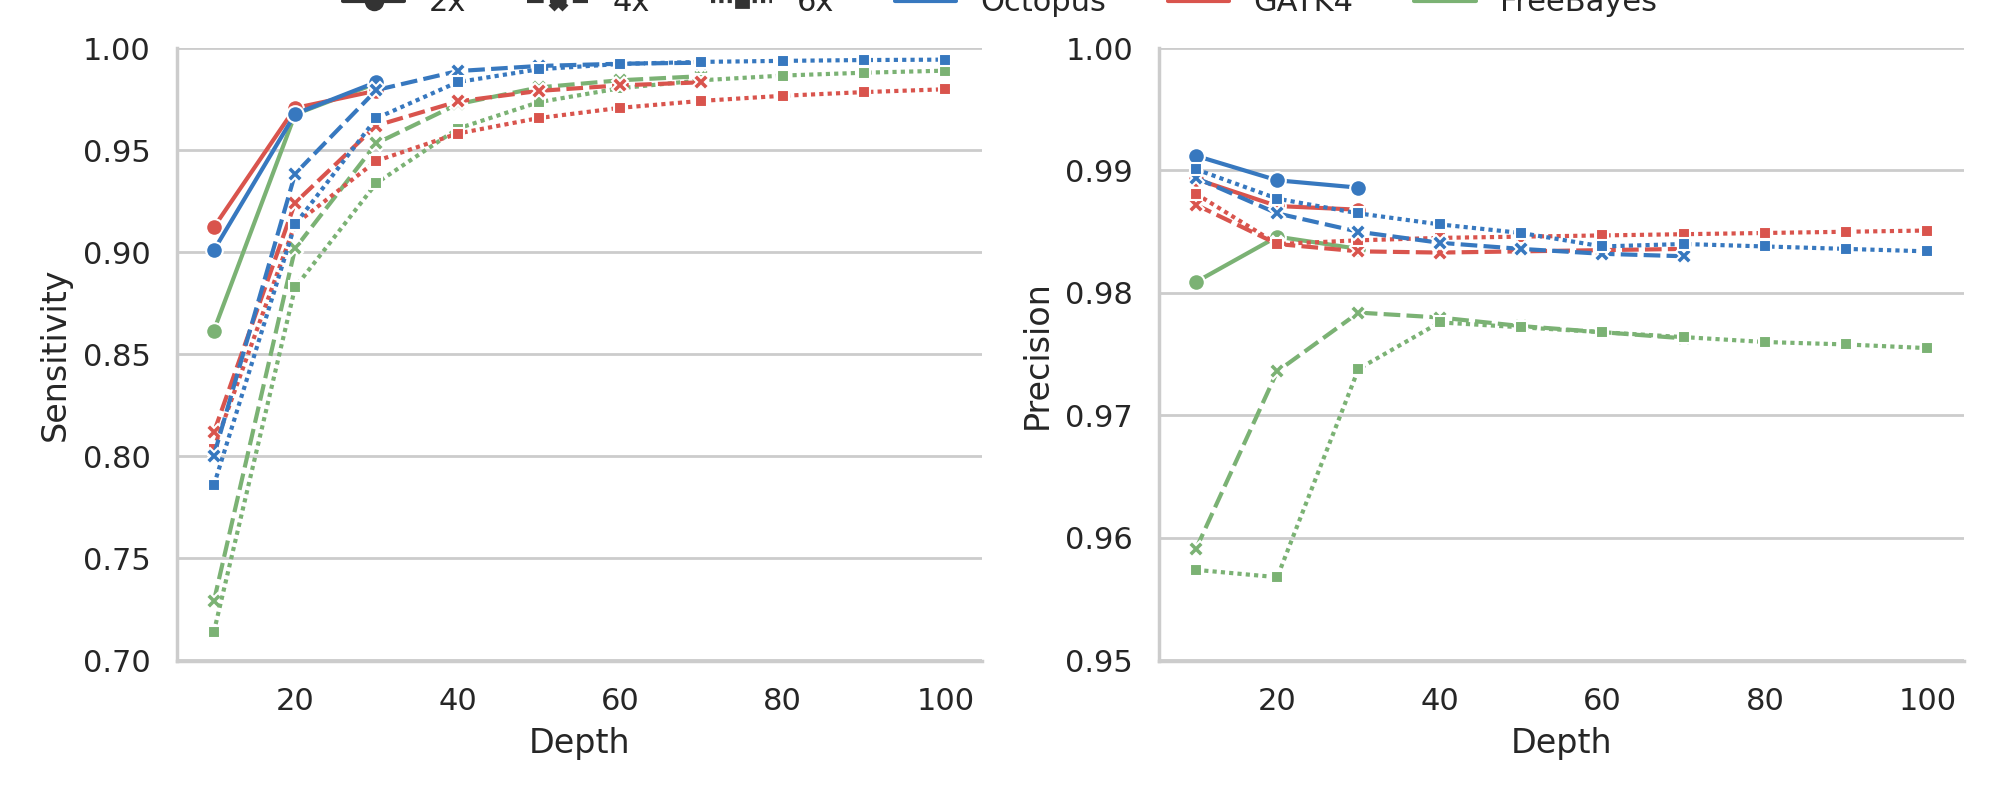

In [563]:
plot_accuracies_by_depth(summary_df.query('Match=="AL" and Library=="NovaSeq" and Filtered==True'),
                         ylims=[(.7, 1.), (.95, 1.)], 
                         y_format='%.2f',
                         metrics=["Sensitivity", "Precision"])

<IPython.core.display.Javascript object>


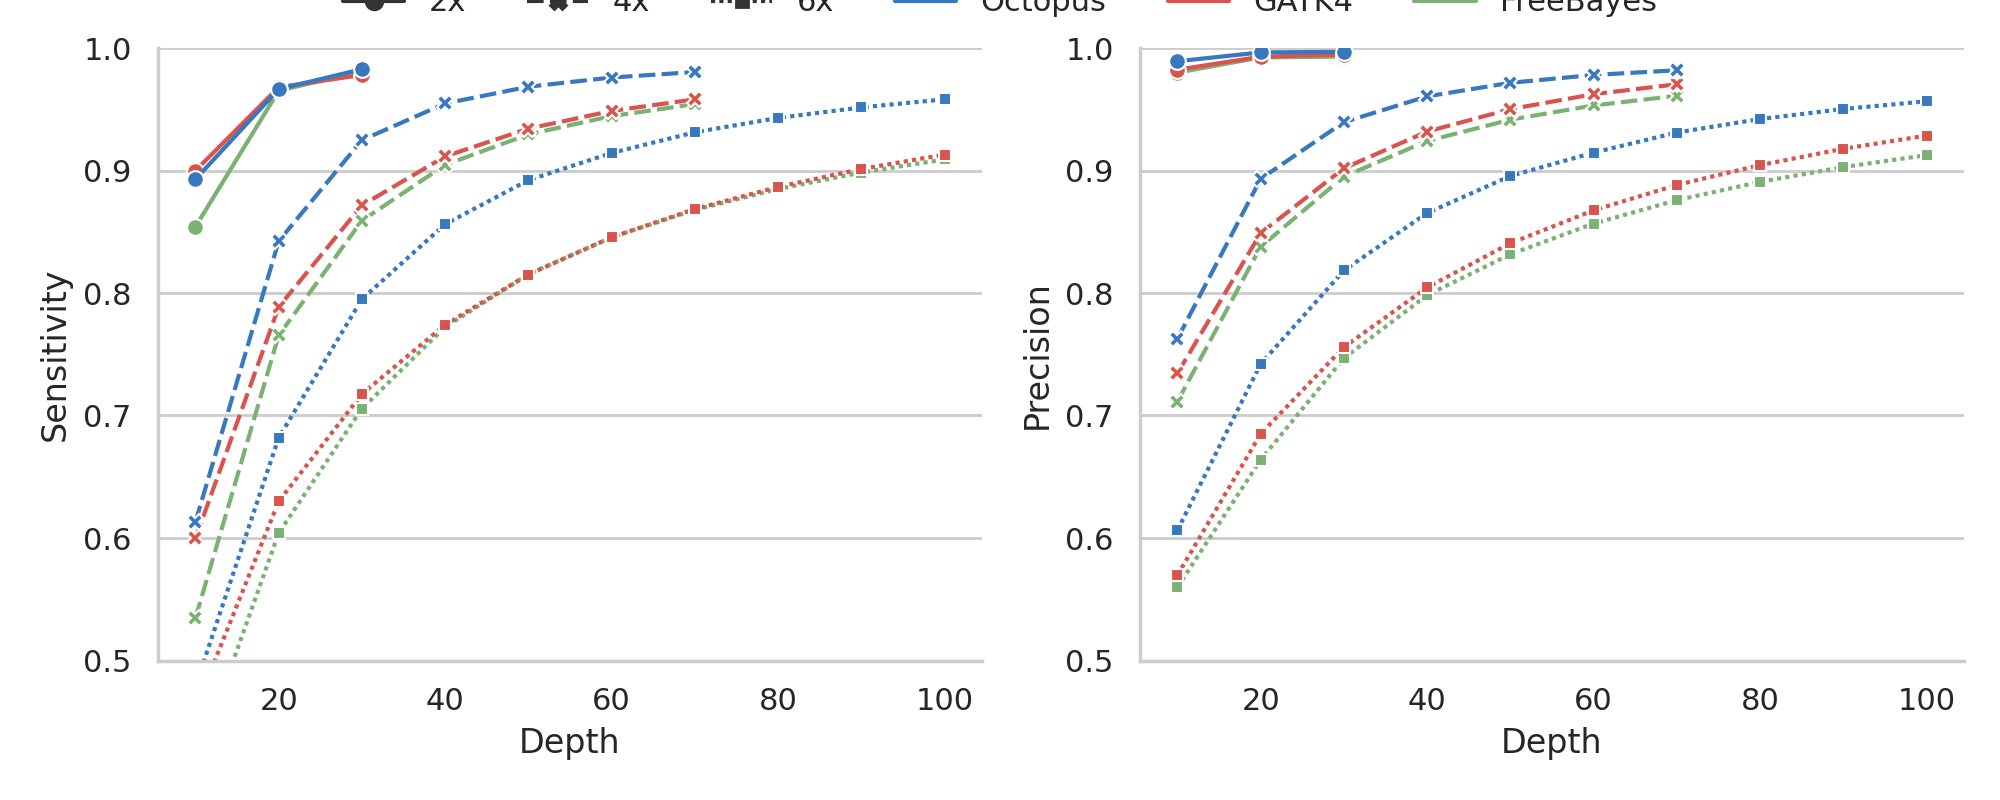

In [559]:
plot_accuracies_by_depth(summary_df.query('Match=="GT" and Library=="NovaSeq" and Filtered==True'),
                         ylim=(0.5, 1.), 
                         metrics=["Sensitivity", "Precision"],
                         save=figure_dir / "sensitivity-and-precision-by-depth.pdf")

<IPython.core.display.Javascript object>


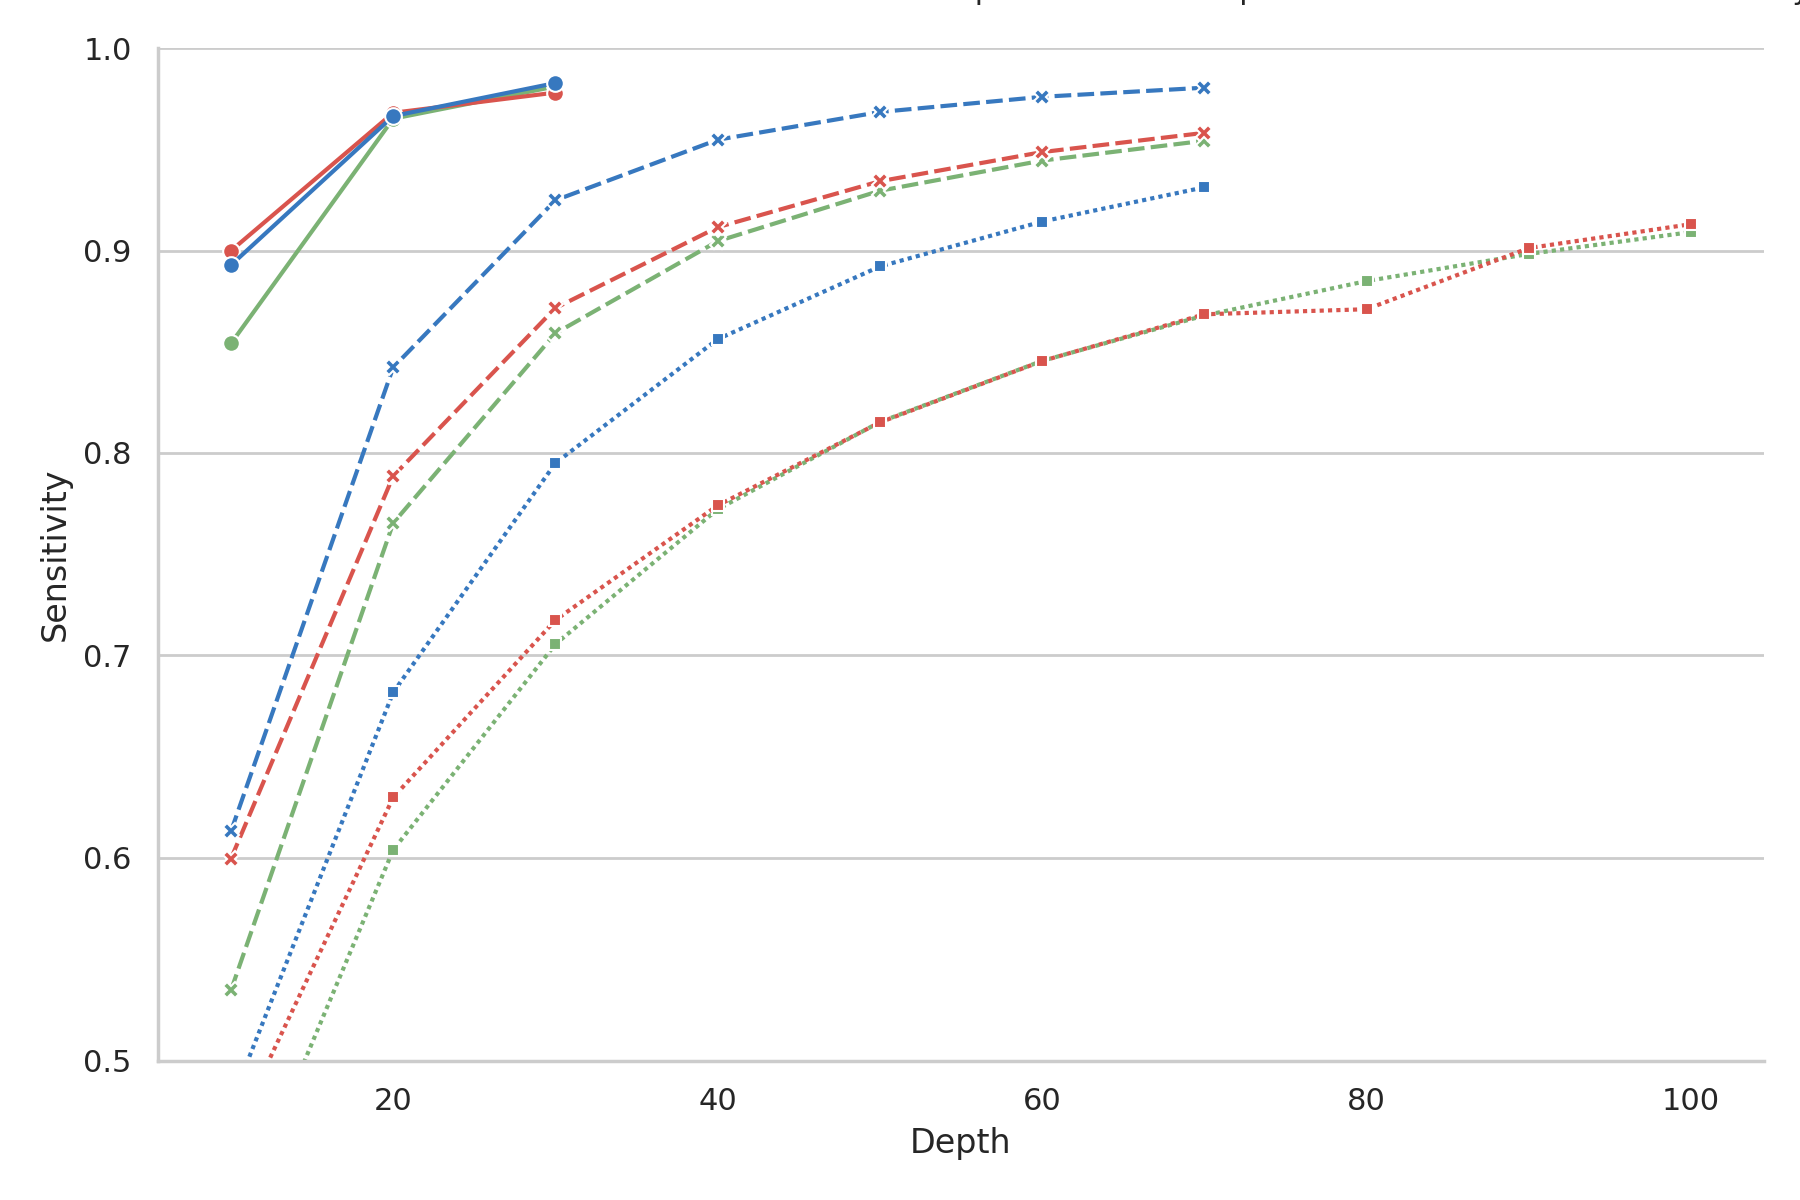

In [159]:
plot_accuracy_by_depth(summary_df.query('Filtered='), ylim=(0.5, 1.), 
                       metric="Sensitivity",
                       save=figure_dir / "sensitivity-by-depth.pdf")

<IPython.core.display.Javascript object>


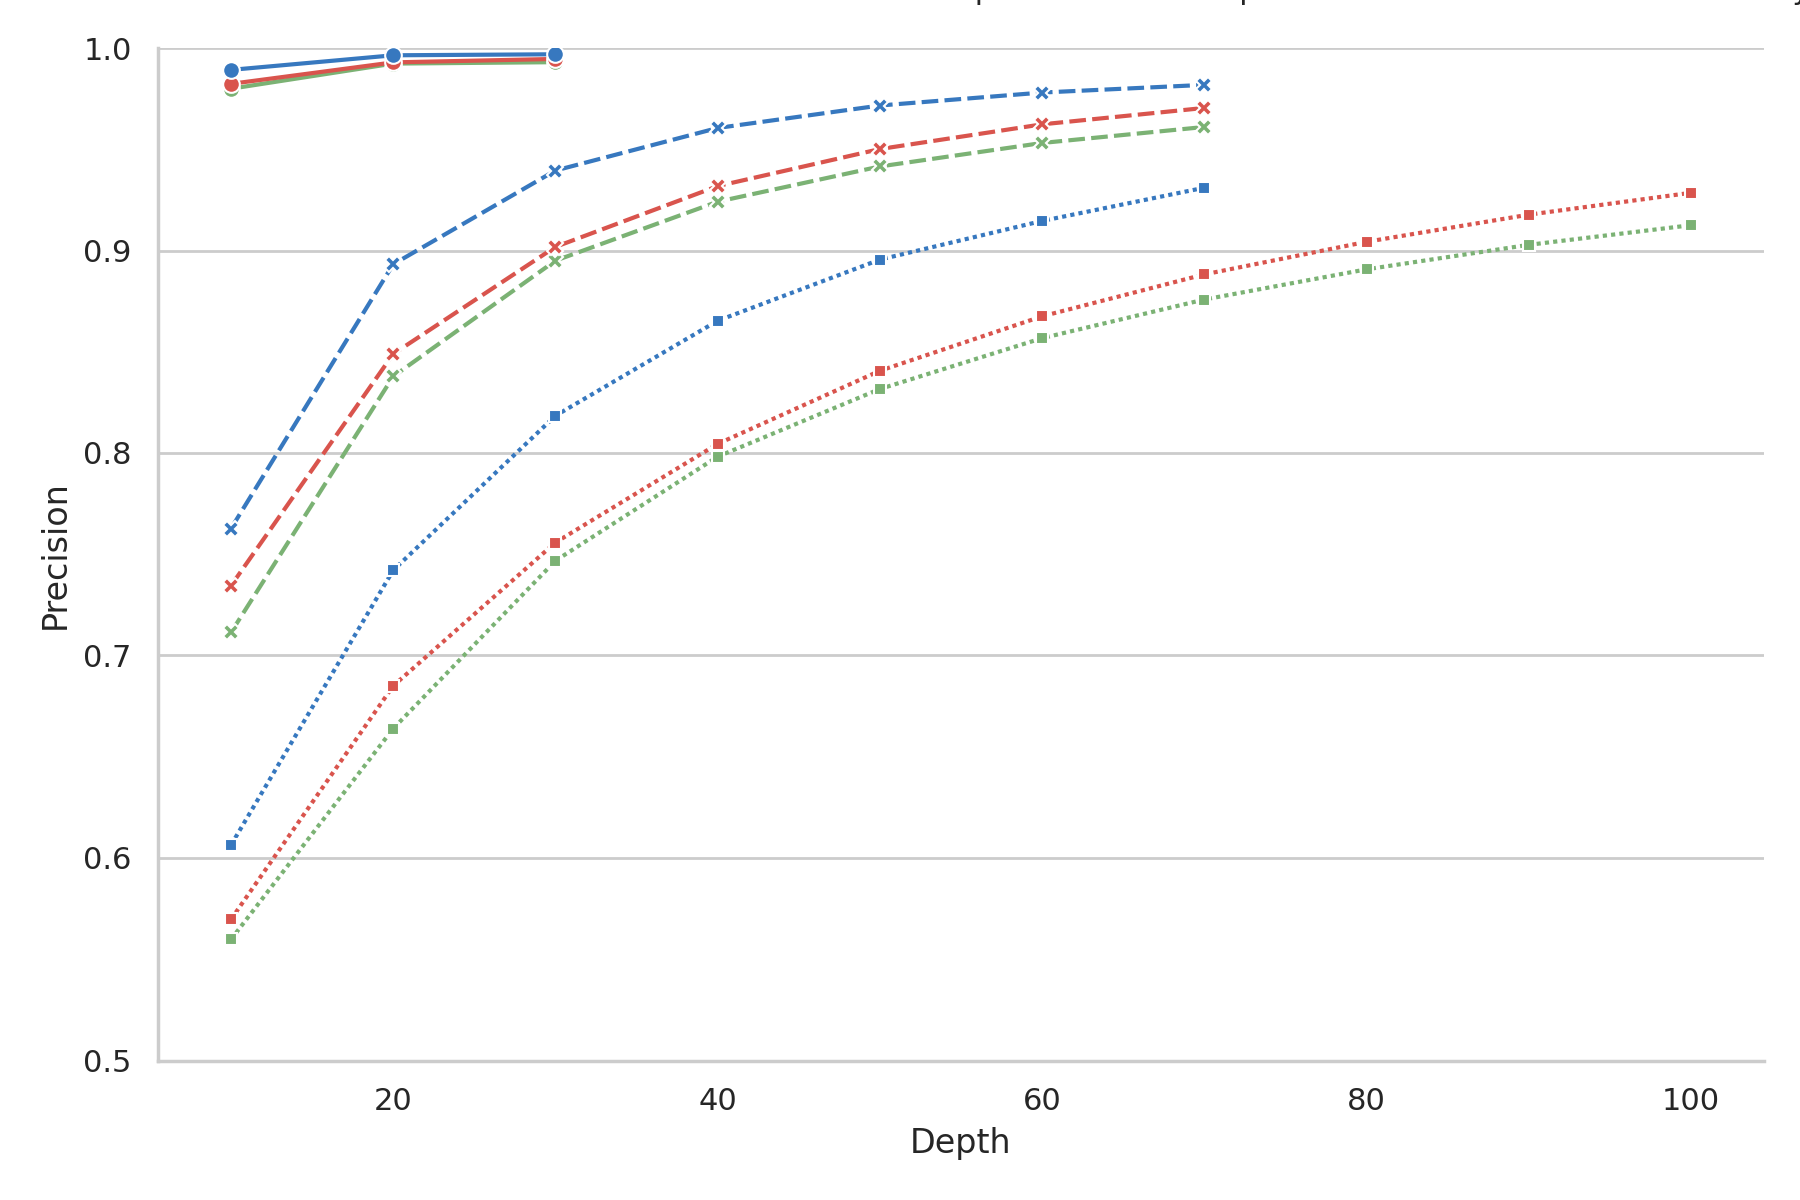

In [157]:
plot_accuracy_by_depth(summary_df.query('Filtered'), ylim=(0.5, 1.), 
                       metric="Precision",
                       save=figure_dir / "precision-by-depth.pdf")

In [ ]:
plot_accuracy_by_depth(summary_df.query('Library=="NovaSeq" and Filtered==True'), ylim=(0.5, 1.), 
                       metric="F-measure",
                       save=figure_dir / "f-measures-by-depth.pdf")

In [290]:
rocs = read_vcfeval_rocs(all_experiments)
filterd_rocs, raw_rocs = rocs.query('Filtered'), rocs.query('not Filtered')

<IPython.core.display.Javascript object>


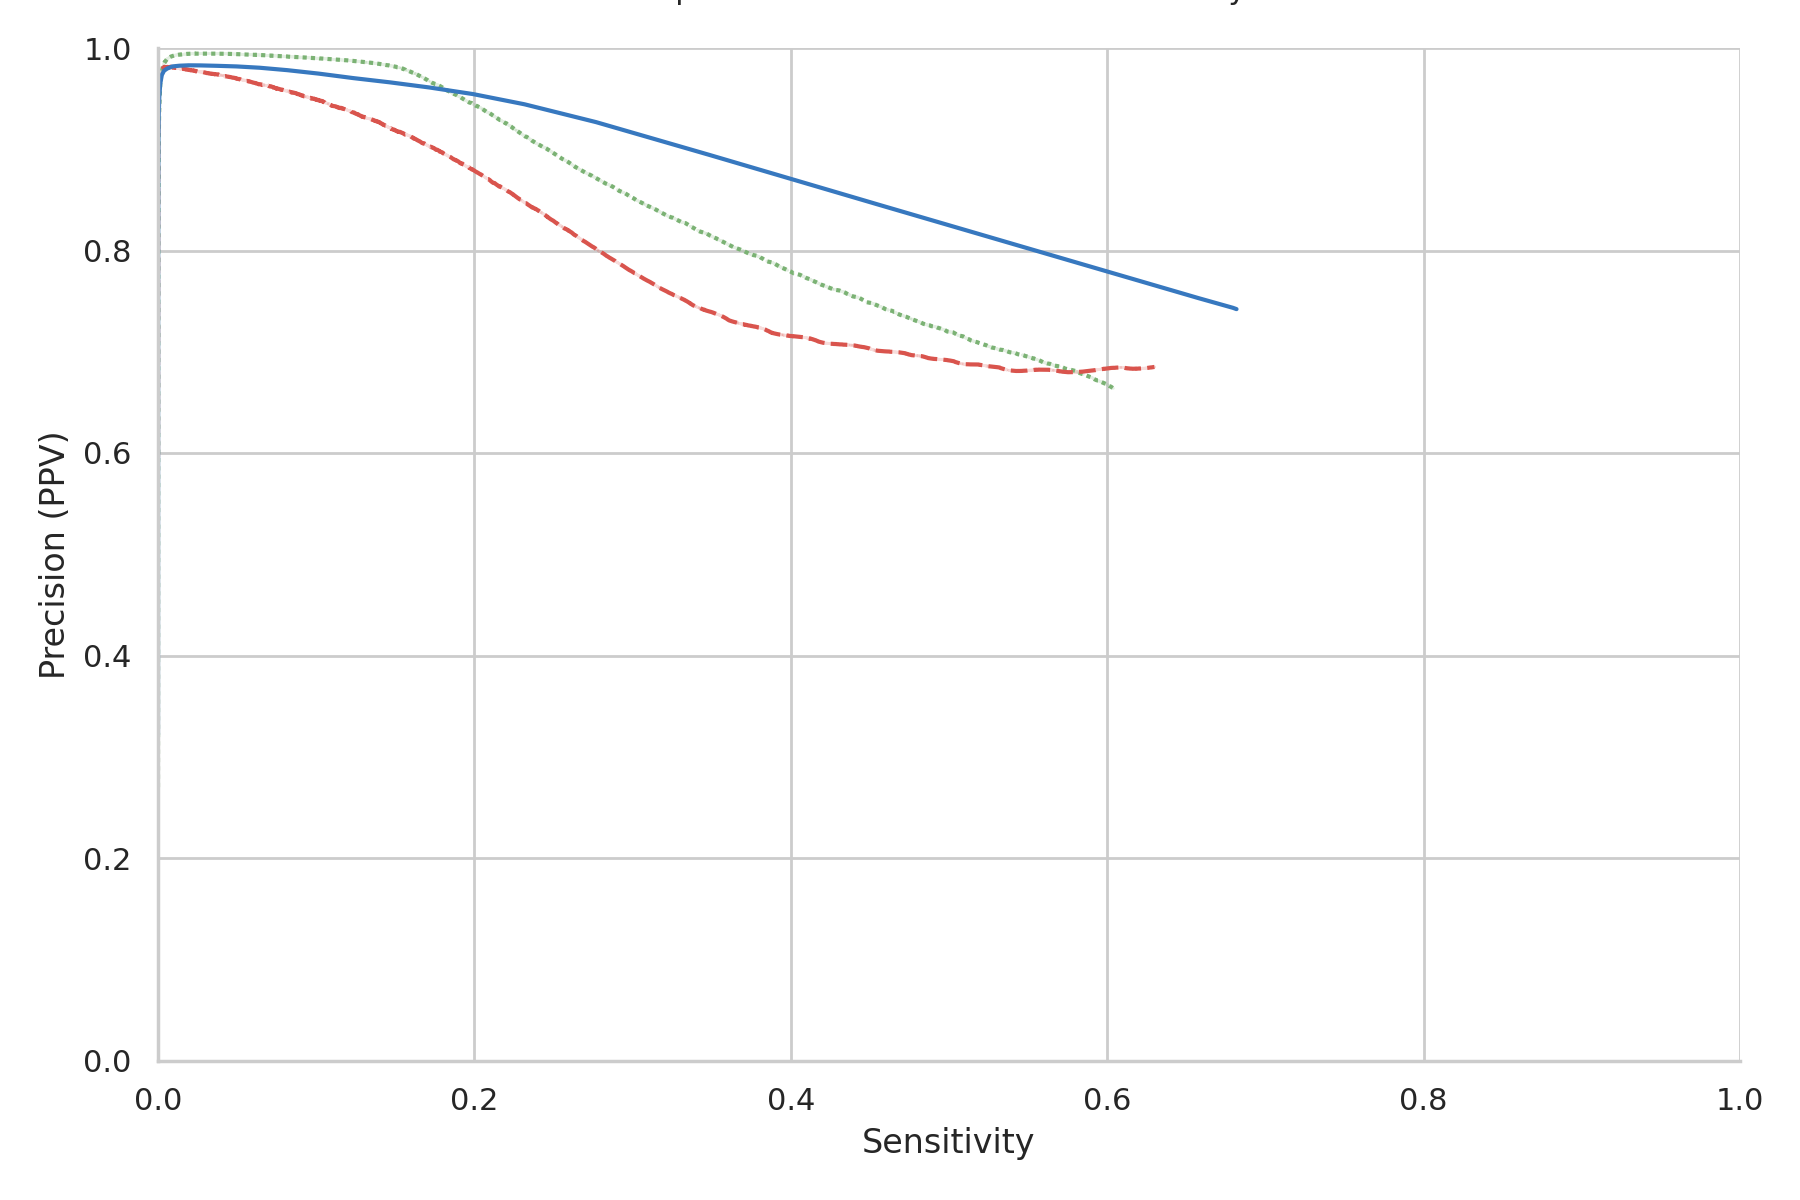

In [222]:
plot_precision_recall(filterd_rocs.query('Sample == "HG002-HG003-HG004" and Depth==20'), xlim=(0., 1.), ylim=(0., 1.))

<IPython.core.display.Javascript object>


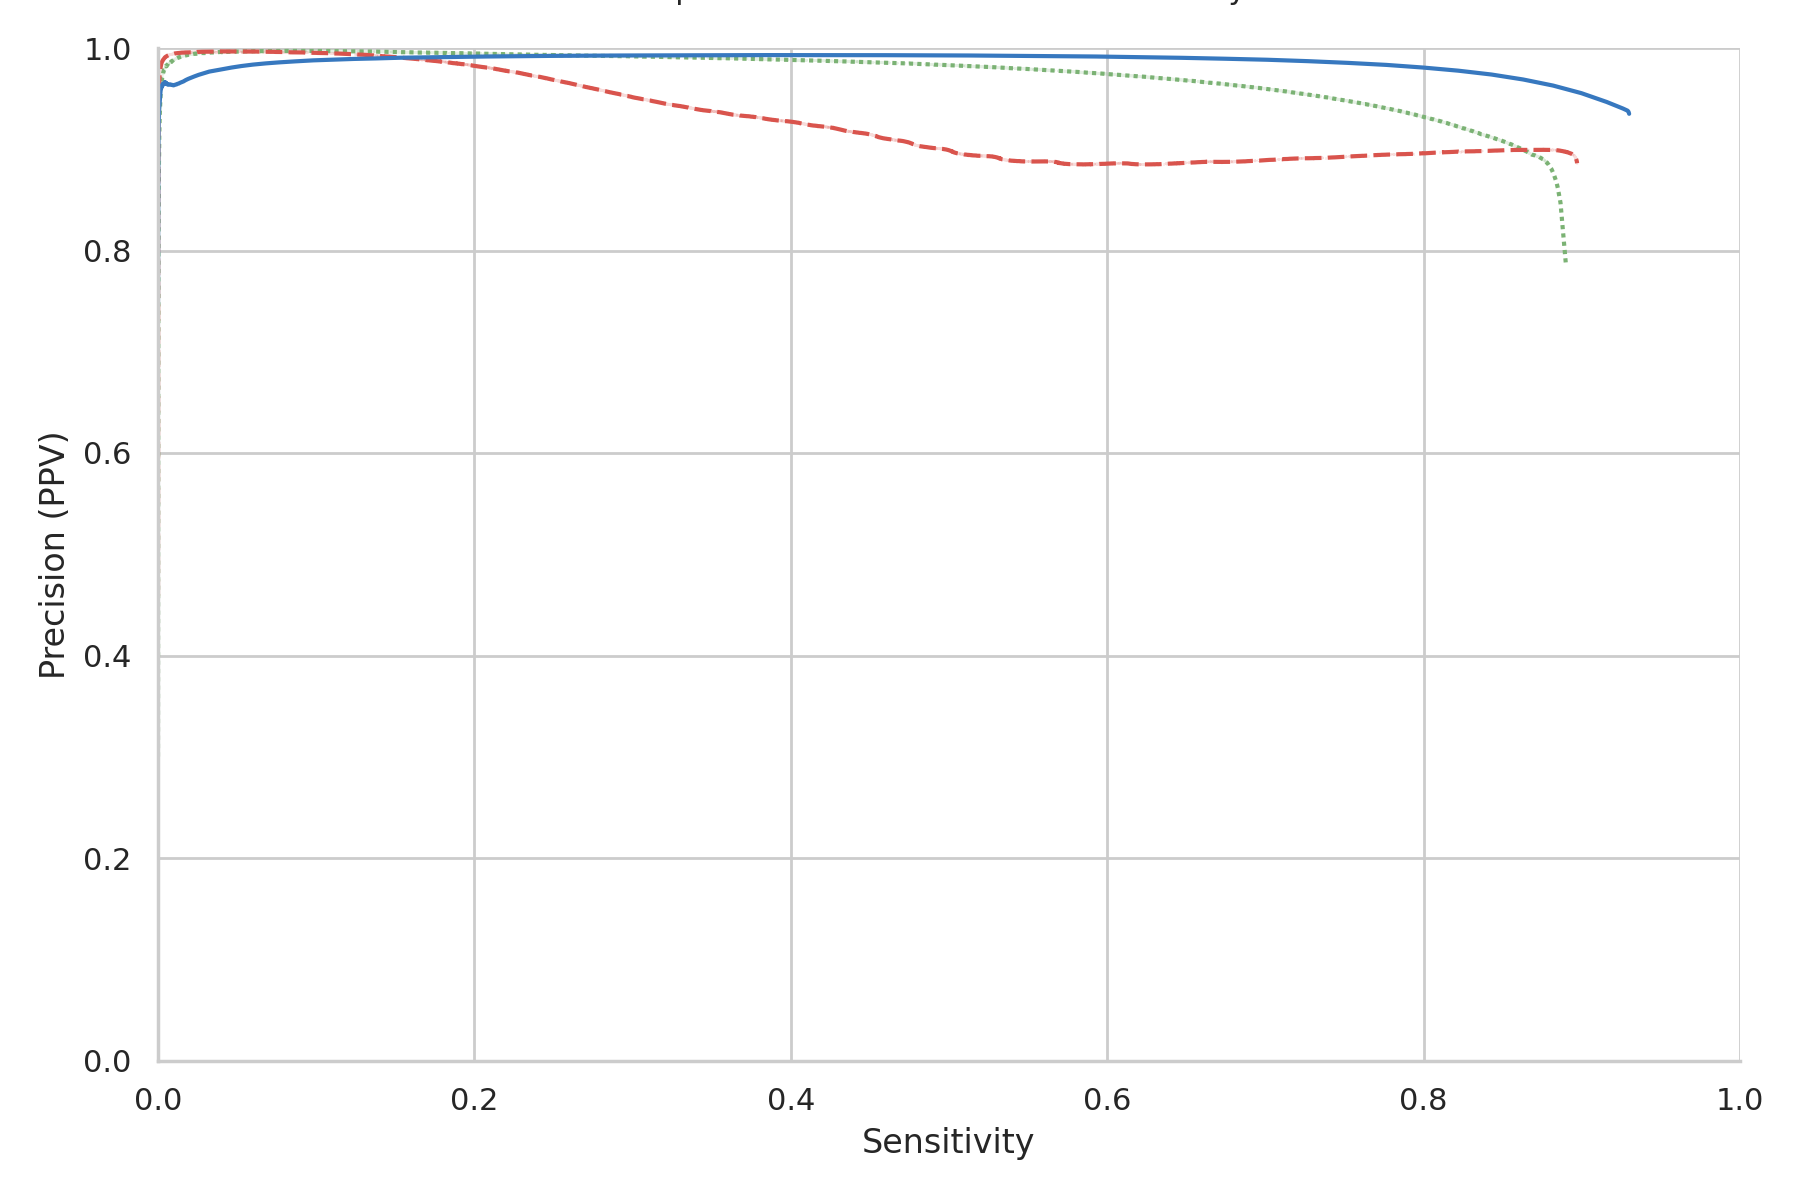

In [163]:
plot_precision_recall(raw_rocs.query('Depth==30'), xlim=(0., 1.), ylim=(0., 1.))

<IPython.core.display.Javascript object>


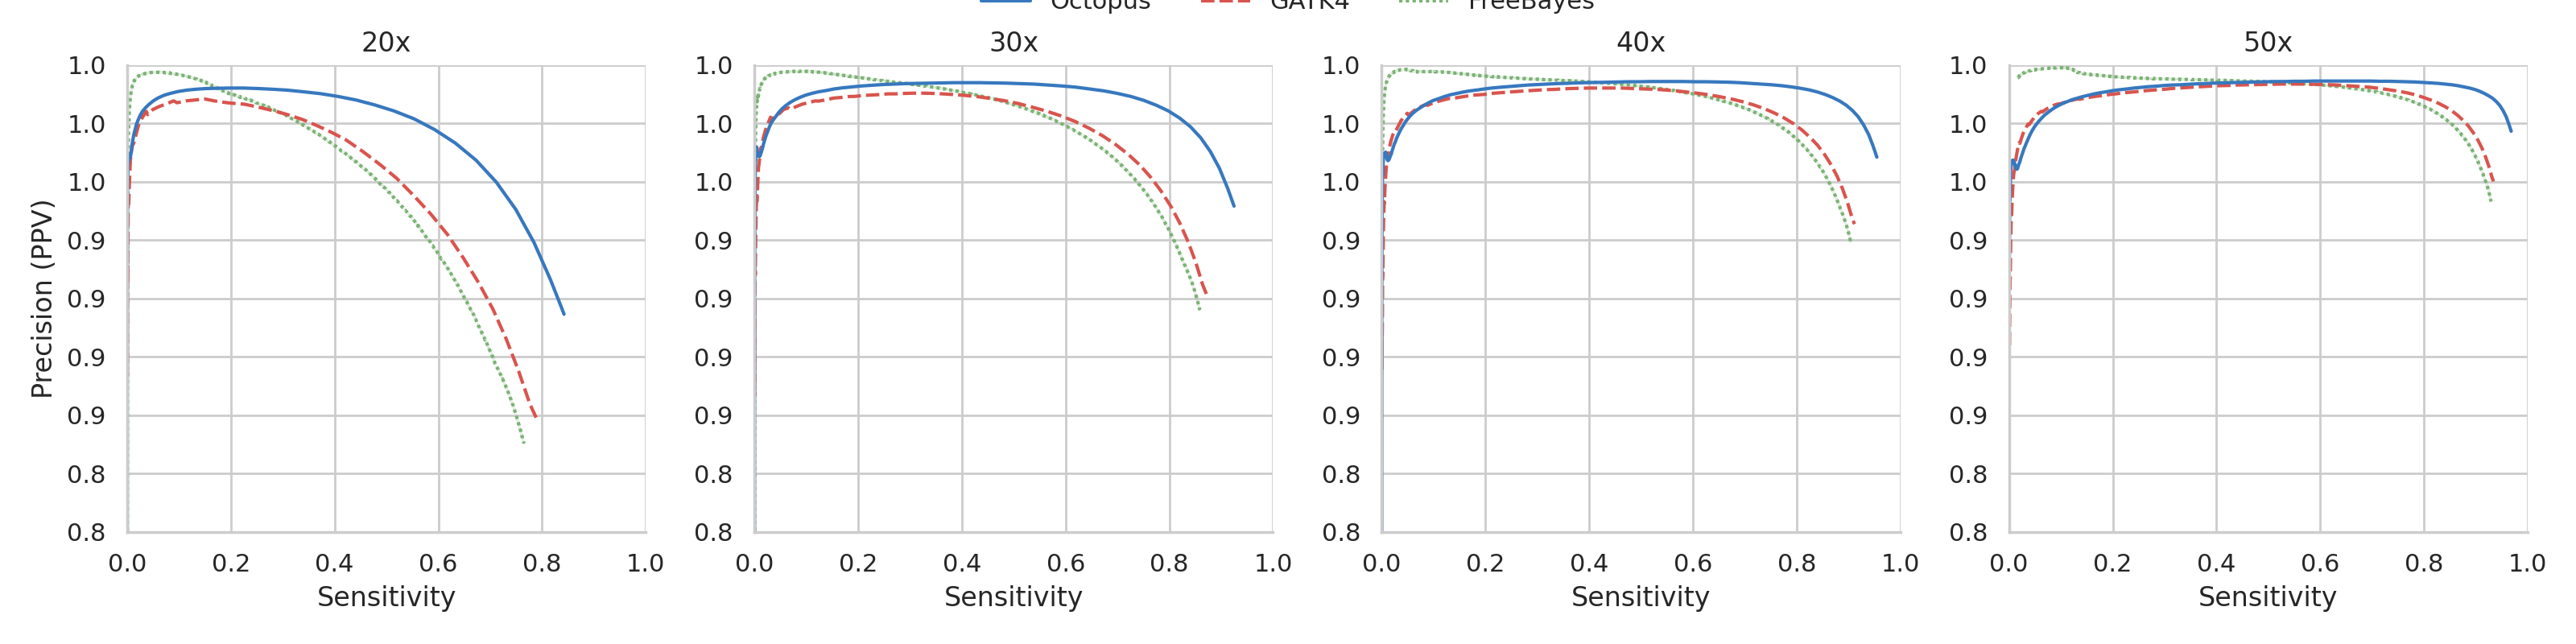

['FreeBayes', 'GATK4', 'Octopus']


In [413]:
data = filterd_rocs.query('Sample=="HG003-HG004" and Library=="NovaSeq"')
depths = data["Depth"].unique()[1:5]
plot_precision_recalls([data.query("Depth==" + str(depth)) for depth in depths],
                       titles=[str(depth) + 'x' for depth in depths],
                       ncols=len(depths),
                       xlims=(0., 1.), ylims=(0.8, 1.),
                       save=figure_dir / "synthetic-tetraploid-pr-curves_20-50x.pdf")

In [316]:
def read_truth_biallelic_gt_counts(sample, reference):
    truth_prefix = truth_dir / (sample + "_" + reference)
    truth_vcf, truth_bed = truth_prefix.with_suffix('.vcf.gz'), truth_prefix.with_suffix('.bed')
    variant_stats = read_variant_stats(truth_vcf, truth_bed)
    ploidy = max([cn for cn, _ in variant_stats["copy_numbers"].items() if type(cn) is int])
    result = {}
    for alt_copies, count in variant_stats["copy_numbers"].items():
        if type(alt_copies) is int:
            ref_copies = ploidy - alt_copies
            gt = ref_copies * 'A' + alt_copies * 'a'
            result[gt] = count
    return result

def read_all_truth_biallelic_gt_counts(experiments):
    result = {}
    for experiment in experiments:
        key = '-'.join(experiment["samples"]), experiment["reference"]
        if key not in result:
            result[key] = read_truth_biallelic_gt_counts(key[0], key[1])
    return result

def read_biallelic_gt_errors(vcfeval_dir, ploidy, truth_counts=None):
    fn_stats = read_variant_stats(vcfeval_dir / "fn.vcf.gz")["copy_numbers"]
    fp_stats = read_variant_stats(vcfeval_dir / "fp.vcf.gz")["copy_numbers"]
    data = []
    total_fn, total_fp = 0, 0
    for ref_copies in range(0, ploidy):
        alt_copies = ploidy - ref_copies
        gt = ref_copies * 'A' + alt_copies * 'a'
        fn = fn_stats[alt_copies] if alt_copies in fn_stats else 0
        fp = fp_stats[alt_copies] if alt_copies in fp_stats else 0
        data += [[gt, "FN", fn], [gt, "FP", fp]]
        total_fn += fn
        total_fp += fp
    for d in data:
        if d[1] == "FN":
            d.append(float(d[2]) / total_fn)
        else:
            d.append(float(d[2]) / total_fp)
    columns=["GT", "Error", "Count", "Fraction"]
    if truth_counts is not None:
        for d in data:
            if d[1] == "FN":
                d.append(float(d[2]) / truth_counts[d[0]])
            else:
                d.append(None)
        columns.append("Truth-fraction")
    return pd.DataFrame(data, columns=columns)

def read_biallelic_error_profiles(experiments):
    truth_counts = read_all_truth_biallelic_gt_counts(experiments)
    return read_vcfeval_df_helper2(experiments, lambda experiment, d: read_biallelic_gt_errors(d, 2 * len(experiment["samples"]), truth_counts=truth_counts[('-'.join(experiment["samples"]), experiment["reference"])]))

In [331]:
biallelic_errors = read_biallelic_error_profiles(synthetic_experiments)
filtered_biallelic_errors, raw_biallelic_errors = biallelic_errors.query('Filtered'), biallelic_errors.query('not Filtered')

In [396]:
def plot_genotype_errors(df, split="Error", kind="Count",
                         ylabel=None,
                         legend=True,
                         save=None, save_format='pdf'):
    g = sns.catplot(x="GT", y=kind,
                    hue="Caller", col=split,
                    palette=caller_colours,
                    kind='bar',
                    legend=legend,
                    data=df)
    for ax in g.axes.flat:
        ax.set_xlabel('')
        if split == "Depth":
            ax.set_title(ax.get_title().split(' ')[-1] + 'x')
    if ylabel is not None:
        g.axes.flat[0].set_ylabel(ylabel)
    if legend:
        handles, labels = g.axes.flat[-1].get_legend_handles_labels()
        lgd = g.fig.legend(handles=handles, labels=labels,
                         frameon=False, loc='upper center',
                         bbox_to_anchor=(0.5, 1.03),
                         borderaxespad=0, ncol=len(labels))
        g.legend.remove()
    plt.tight_layout()
    if save is None:
        plt.show()
    else:
        plt.savefig(save, format=save_format, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


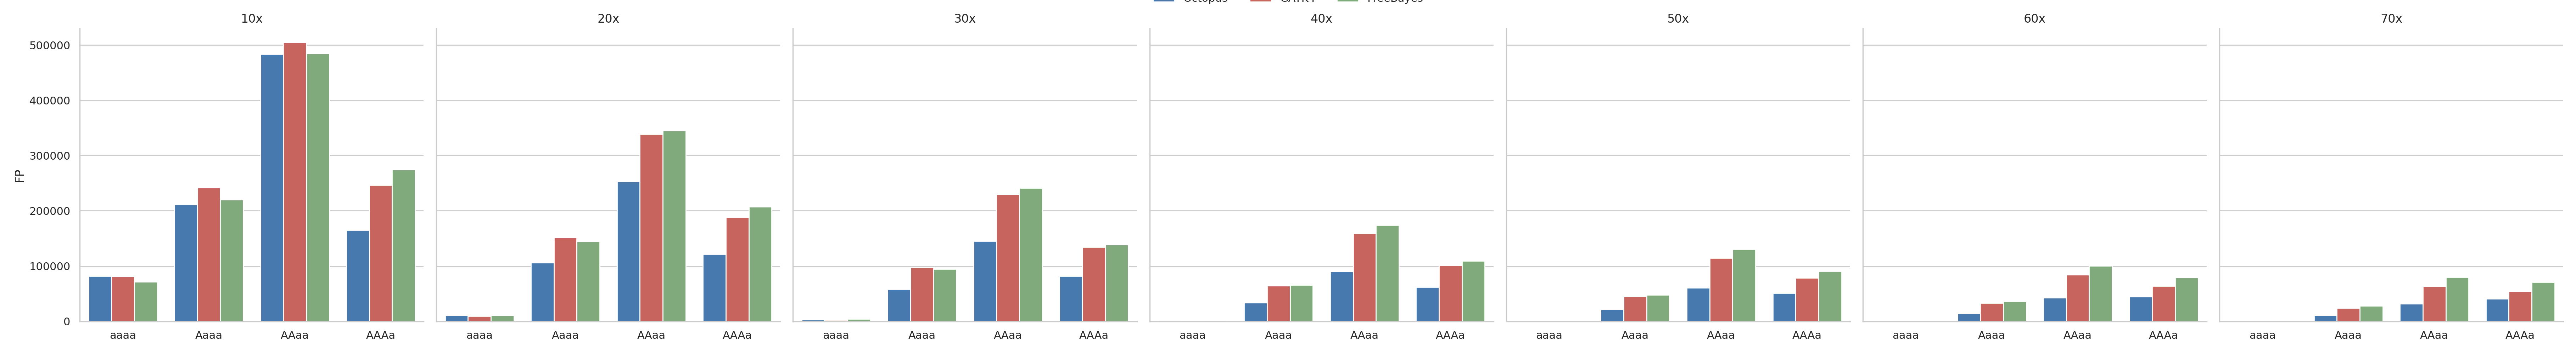

In [399]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG003-HG004' and Error=='FP'"),
                     kind="Count", split="Depth",
                     ylabel="FP",
                     save=figure_dir / "tetraploid_gt_fp.pdf")

<IPython.core.display.Javascript object>


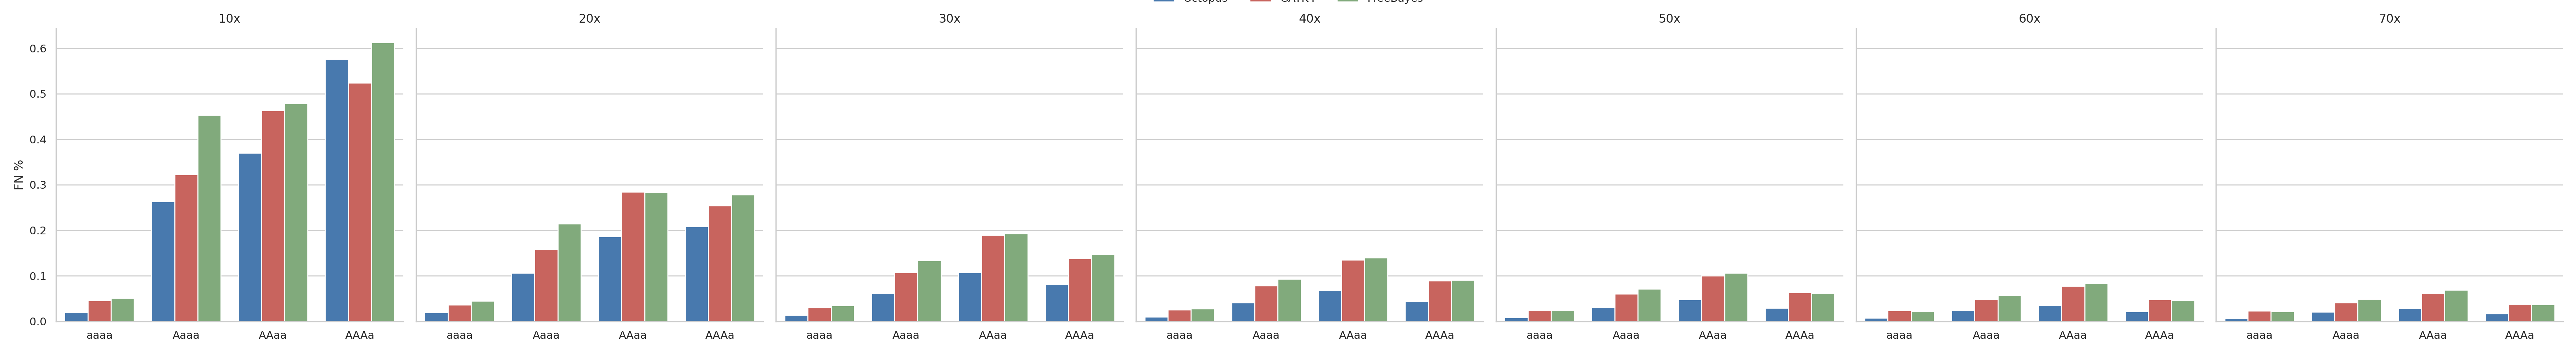

In [400]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG003-HG004' and Error=='FN'"),
                     kind="Truth-fraction", split="Depth",
                     ylabel="FN %",
                     save=figure_dir / "tetraploid_gt_fn_perc.pdf")

<IPython.core.display.Javascript object>


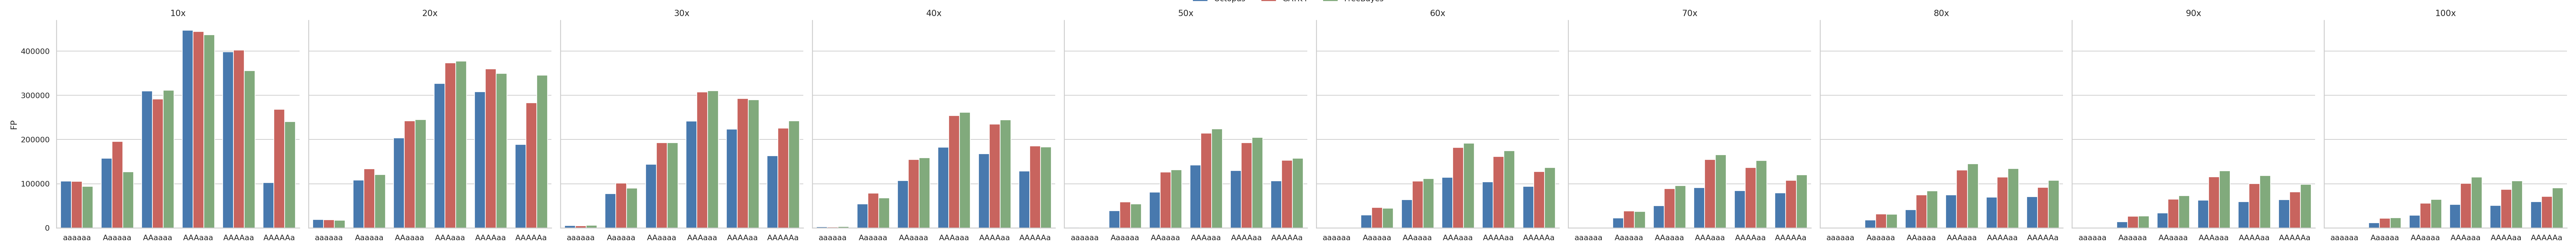

In [404]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG002-HG003-HG004' and Error=='FP'"),
                     kind="Count", split="Depth",
                     ylabel="FP",
                     save=figure_dir / "hexaploid_gt_fp.pdf")

In [409]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG002-HG003-HG004' and 10<=Depth<=60 and Error=='FP'"),
                     kind="Count", split="Depth",
                     ylabel="FP",
                     save=figure_dir / "hexaploid_gt_fp_10-60x.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


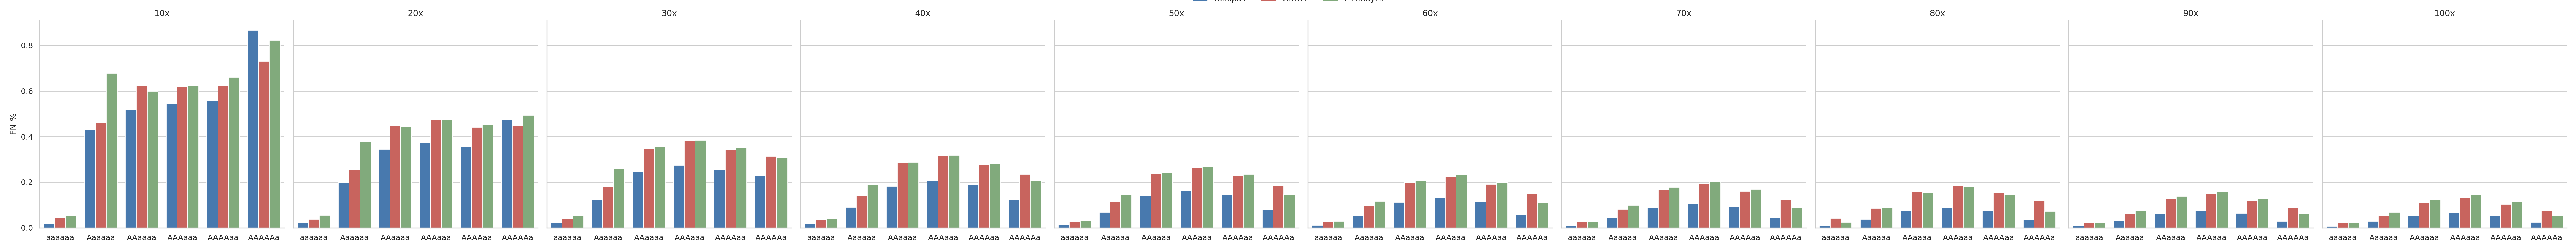

In [403]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG002-HG003-HG004' and Error=='FN'"),
                     kind="Truth-fraction", split="Depth",
                     ylabel="FN %",
                     save=figure_dir / "hexaploid_gt_fn_perc.pdf")

<IPython.core.display.Javascript object>


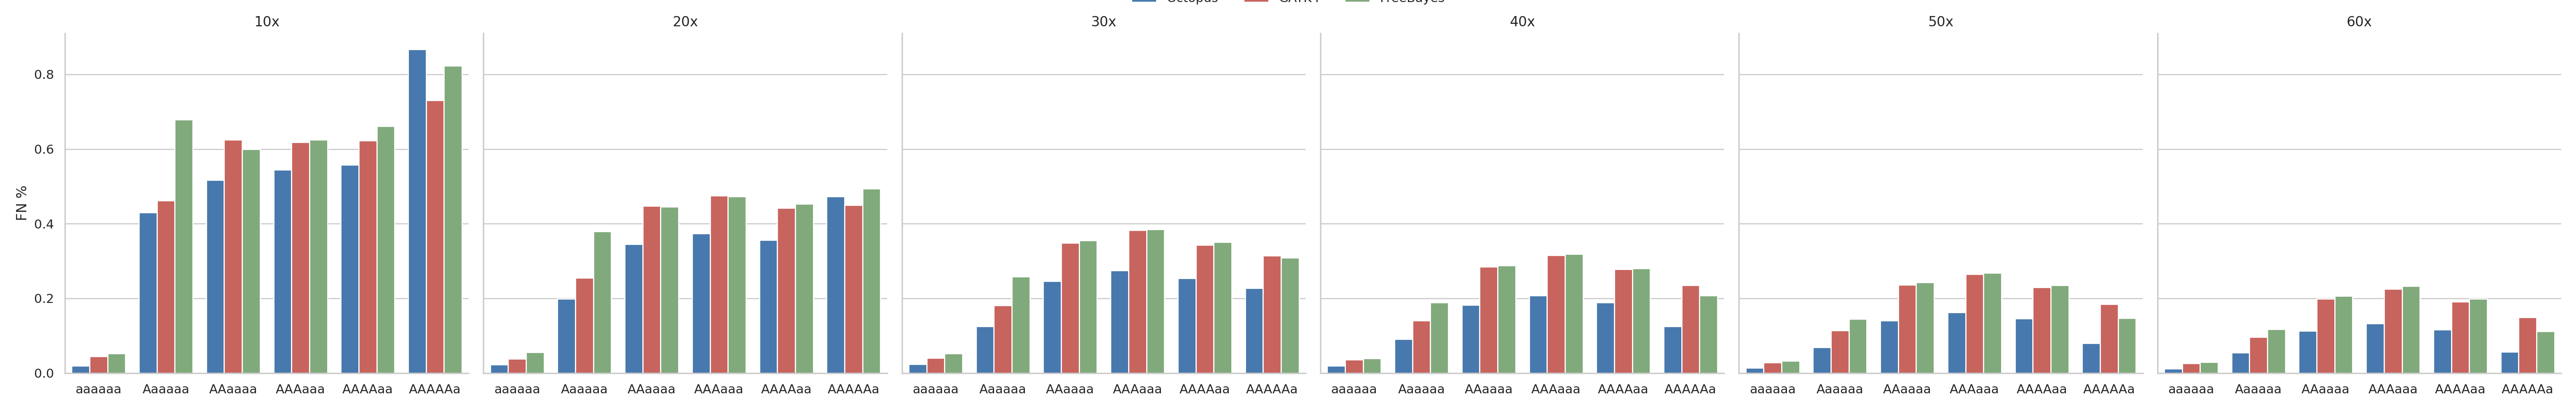

In [410]:
plot_genotype_errors(filtered_biallelic_errors.query("Library=='NovaSeq' and Sample=='HG002-HG003-HG004' and 10<=Depth<=60 and Error=='FN'"),
                     kind="Truth-fraction", split="Depth",
                     ylabel="FN %",
                     save=figure_dir / "hexaploid_gt_fn_perc_10-60x.pdf")

In [214]:
pacbio_experiment = {
    "reference": "hs38DH",
    "samples": ["HG003", "HG004"],
    "library": "PacBioHiFi",
    "depth": 50,
    "callers": all_callers,
    "calling_regions": "autosomes",
    "caller_options": {
        "Octopus": {
            "--max-genotypes": 10000,
            "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
        }
    }
}

In [213]:
run_experiments([pacbio_experiment], asynchronous=True)

NameError: name 'pacbio_experiment' is not defined

In [550]:
pacbio_single_sample_experiments = [
    {
        "reference": "hs38DH",
        "samples": ["HG002"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
    {
        "reference": "hs38DH",
        "samples": ["HG003"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
    {
        "reference": "hs38DH",
        "samples": ["HG004"],
        "library": "PacBioHiFi",
        "depth": 35,
        "callers": all_callers,
        "calling_regions": "autosomes",
        "caller_options": {
            "Octopus": {
                "--config": octopus_dir / "resources" / "configs" / "PacBioCCS.config"
            }
        }
    },
]

In [551]:
run_experiments(pacbio_single_sample_experiments, asynchronous=True)

bin/pbmm2 align data/references/hs38DH.fa data/fastq/HG002_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG002.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG002\tLB:POLYPLOID\tPL:PacBioHiFi --sort
qsub -cwd -V -N pbmm2 -j y -o log/pbmm2_3701.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_3701.shbin/pbmm2 align data/references/hs38DH.fa data/fastq/HG003_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG003.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG003\tLB:POLYPLOID\tPL:PacBioHiFi --sort

qsub -cwd -V -N pbmm2 -j y -o log/pbmm2_35056.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_35056.sh
bin/pbmm2 align data/references/hs38DH.fa data/fastq/HG004_35x_PacBio_14kb-15kb.fastq.gz data/bam/HG004.PacBioHiFi.35x.hs38DH.bam --preset HIFI -j 20 -J 10.0 --rg @RG\tID:None\tSM:HG004\tLB:POLYPLOID\tPL:PacBioHiFi --sort
qsub -cwd -V -N pbmm2 -j y -o log/pbmm2_8818.log -P lunter.prjc -q short.qf -pe shmem 20 tmp/pbmm2_8818.sh
bin/octopus

In [239]:
def run_starfish(ref_sdf, vcfs, out_dir,
                 ploidy=2,
                 names=None,
                 threads=20,
                 show_command=True,
                 qsub=False):
    starfish_cmd = ['python3', starfish_bin, \
                    '--bcftools', bcftools_bin, \
                    '--rtg', rtg_bin, \
                    '-t', ref_sdf, \
                    '-O', our_dir, \
                    '--ploidy', str(ploidy), \
                    '--ref-overlap', \
                    '-V'] + vcfs
    if names is not None:
        starfish_cmd += ['--names'] + names
        starfish_cmd += ['--vennout', 'venn.pdf']
    if show_command:
        print(' '.join(str(c) for c in starfish_cmd))
    if qsub:
        qsub_command(rtg_cmd, name="starfish", time=False, cores=threads, show_command=show_command, wait_until_finished=False)
    else:
        sp.call(starfish_cmd)

In [451]:
def count_vcf_records(vcf_filename):
    vcf = ps.VariantFile(vcf_filename)
    return sum(1 for rec in vcf)

In [569]:
isec_dir = Path("/well/dcooke/polyploid/results/isec/banana")
labels = ["Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"]
isec_counts = []
expressions = []
for file in isec_dir.glob('**/*'):
    if file.suffix == ".gz" and file.name[0].isalpha():
        row = [False for _ in range(len(labels))]
        for label in file.name.split('.')[0]:
            row[ord(label) - ord('A')] = True
        count = count_vcf_records(file)
        hotlabels = '&'.join([labels[i] for i, x in enumerate(row) if x])
        expressions.append("'" + hotlabels + "'" + '=' + str(count))
        row.append(count)
        isec_counts.append(row)
banana_isec_df = pd.DataFrame(isec_counts, columns=[label.replace('.', '_') for label in labels] + ["Count"])
print(','.join(expressions))

'Octopus.HiSeq&GATK.HiSeq&FreeBayes.NextSeq'=10580,'GATK.HiSeq&FreeBayes.HiSeq'=243984,'GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=83558,'FreeBayes.HiSeq&FreeBayes.NextSeq'=367967,'Octopus.HiSeq&GATK.NextSeq&FreeBayes.HiSeq'=15403,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&FreeBayes.HiSeq'=140179,'Octopus.HiSeq&GATK.HiSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=87228,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=6971494,'Octopus.HiSeq&Octopus.NextSeq&FreeBayes.HiSeq'=81852,'GATK.HiSeq'=788613,'Octopus.NextSeq&FreeBayes.NextSeq'=126830,'GATK.HiSeq&FreeBayes.NextSeq'=32932,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=425067,'Octopus.HiSeq&Octopus.NextSeq&GATK.NextSeq&FreeBayes.NextSeq'=101013,'Octopus.HiSeq&FreeBayes.HiSeq'=188284,'Octopus.NextSeq&GATK.HiSeq&GATK.NextSeq&FreeBayes.NextSeq'=47935,'Octopus.NextSeq&GATK.HiSeq'=43974,'Octopus.HiSeq&GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=34474,'Octopus.HiSeq&G

<IPython.core.display.Javascript object>


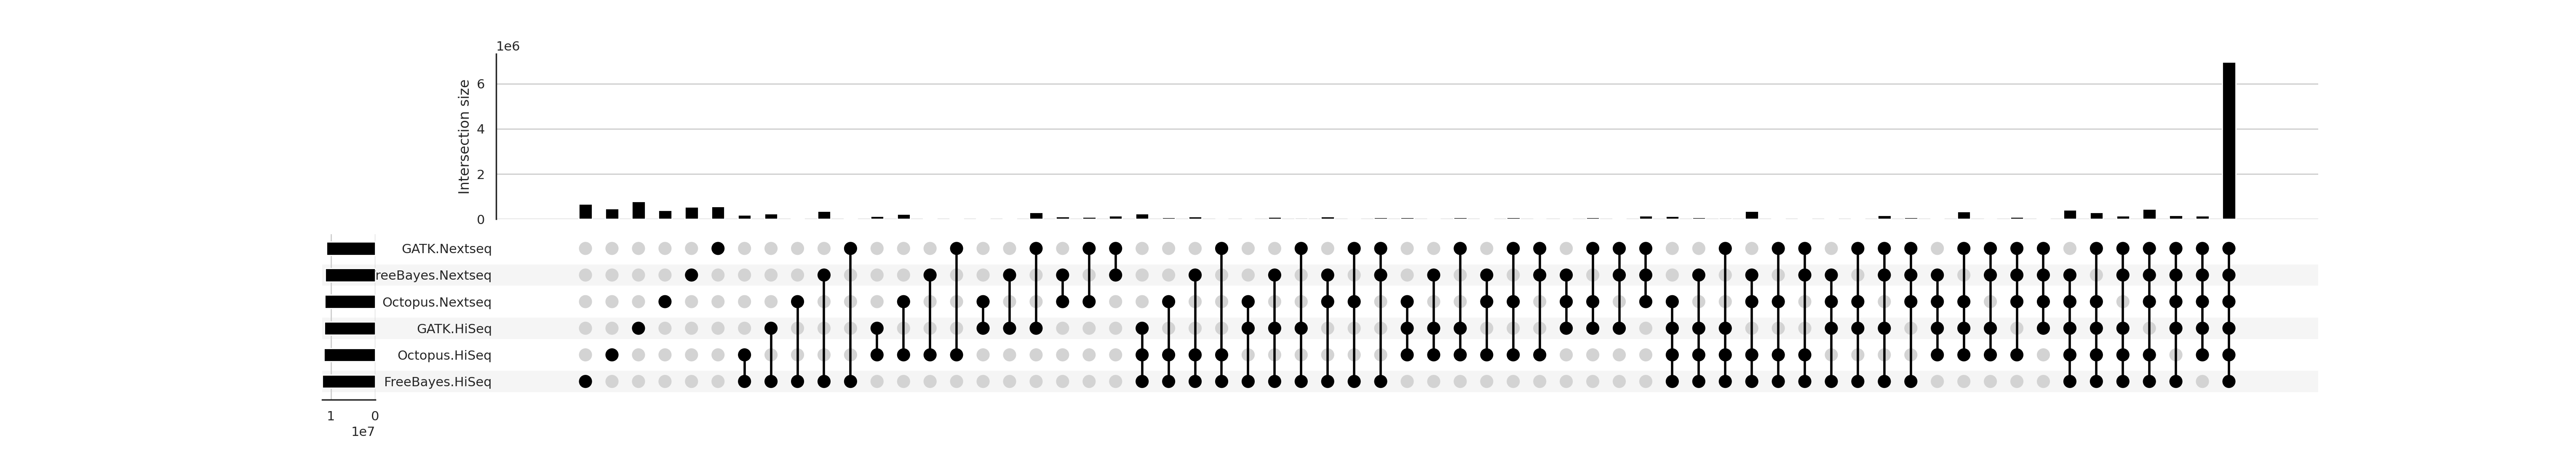

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

In [548]:
sns.set(style="white")
usp.plot(banana_isec_df.groupby(labels).sum()["Count"])

In [571]:
banana_isec_df

Octopus_HiSeq  Octopus_NextSeq  GATK_HiSeq  GATK_NextSeq  FreeBayes_HiSeq  \
0            True            False        True         False            False   
1           False            False        True         False             True   
2           False            False       False          True             True   
3           False            False       False         False             True   
4            True            False       False          True             True   
..            ...              ...         ...           ...              ...   
58           True             True       False          True             True   
59          False            False        True          True            False   
60           True            False        True         False            False   
61          False             True       False          True            False   
62           True            False       False         False             True   

    FreeBayes_NextSeq   Count  
0                True   10580  
1               False  243984  
2                True   83558  
3                True  367967  
4               False   15403  
..                ...     ...  
58              False   33312  
59               True   41436  
60              False  142439  
61              False  104261  
62               True  112040  

[63 rows x 7 columns]

In [613]:
banana_isec_df['Count'].sum()

17277217

In [577]:
banana_isec_df.query('Octopus_HiSeq and Octopus_NextSeq').groupby(list(banana_isec_df.columns[:-1])).sum()["Count"]

Octopus_HiSeq  Octopus_NextSeq  GATK_HiSeq  GATK_NextSeq  FreeBayes_HiSeq  FreeBayes_NextSeq
True           True             False       False         False            False                 224420
                                                                           True                   48596
                                                          True             False                  81852
                                                                           True                  372124
                                            True          False            False                  83905
                                                                           True                  101013
                                                          True             False                  33312
                                                                           True                  463464
                                True        False         False            

In [582]:
def sum_counts(isec_df, caller, match):
    if match:
        return isec_df.query(caller + '_HiSeq and ' + caller + '_NextSeq').groupby(list(banana_isec_df.columns[:-1])).sum()["Count"].sum()
    else:
        res = 0
        res += isec_df.query('not ' + caller + '_HiSeq and ' + caller + '_NextSeq').groupby(list(banana_isec_df.columns[:-1])).sum()["Count"].sum()
        res += isec_df.query(caller + '_HiSeq and not ' + caller + '_NextSeq').groupby(list(banana_isec_df.columns[:-1])).sum()["Count"].sum()
        return res

In [586]:
banana_isec_totals = pd.DataFrame([
    ["Octopus", True, sum_counts(banana_isec_df, "Octopus", True)],
    ["Octopus", False, sum_counts(banana_isec_df, "Octopus", False)],
    ["GATK4", True, sum_counts(banana_isec_df, "GATK", True)],
    ["GATK4", False, sum_counts(banana_isec_df, "GATK", False)],
    ["FreeBayes", True, sum_counts(banana_isec_df, "FreeBayes", True)],
    ["FreeBayes", False, sum_counts(banana_isec_df, "FreeBayes", False)]
], columns=["Caller", "Concordant", "Genotypes"])

In [604]:
banana_isec_totals

Caller  Concordant  Genotypes
0    Octopus        True    9854737
1    Octopus       False    3219611
2      GATK4        True    9025920
3      GATK4       False    4421440
4  FreeBayes        True    9778611
5  FreeBayes       False    3729699

In [606]:
banana_isec_totals_wide = banana_isec_totals.pivot(index='Caller', columns='Concordant', values='Genotypes')

In [607]:
banana_isec_totals_wide

Concordant    False    True 
Caller                      
FreeBayes   3729699  9778611
GATK4       4421440  9025920
Octopus     3219611  9854737

In [612]:
with open(tables_dir / "banana_concorance_totals.tex", 'w') as table:
    table.write(banana_isec_totals_wide.to_latex(bold_rows=True))

<IPython.core.display.Javascript object>


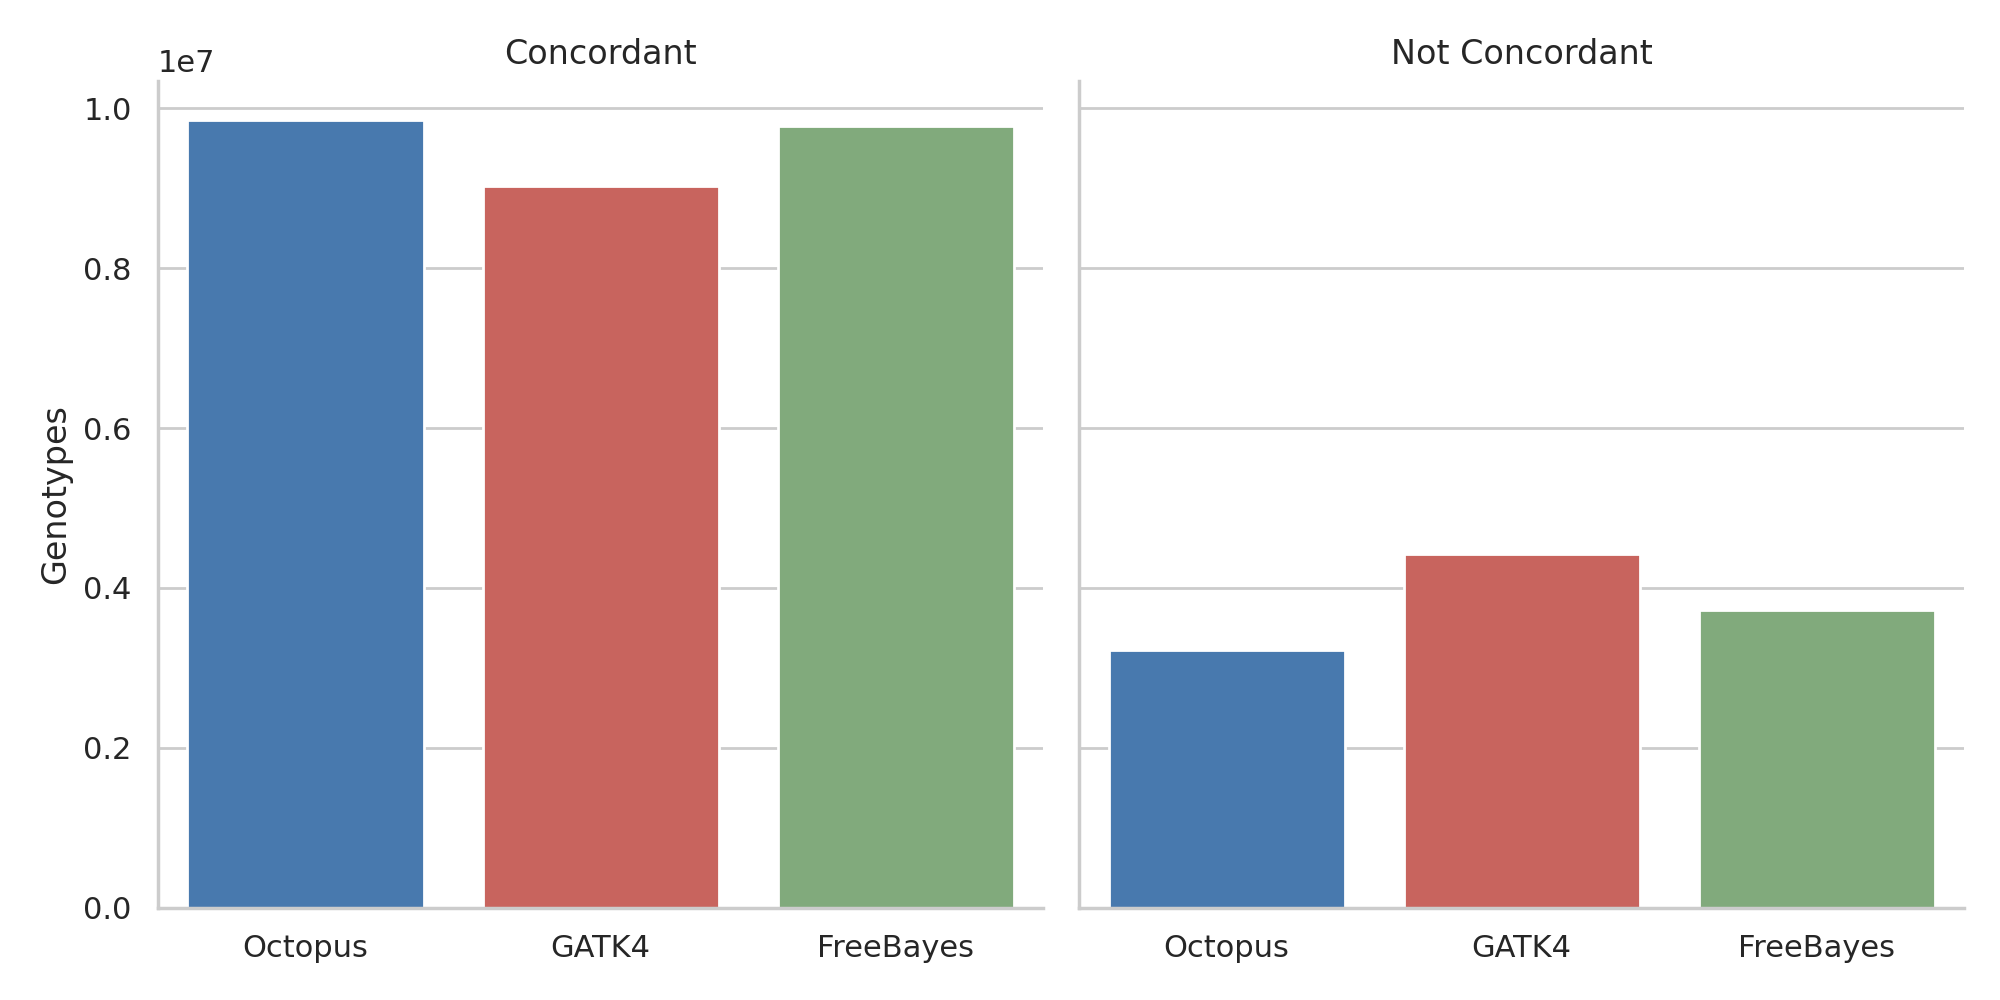

In [603]:
g = sns.catplot(x="Caller", y="Genotypes", 
                col="Concordant",
                kind='bar',
                col_order=[True, False],
                palette=caller_colours,
                data=banana_isec_totals)
g.axes.flat[0].set_title("Concordant")
g.axes.flat[1].set_title("Not Concordant")
g.axes.flat[0].set_xlabel("")
g.axes.flat[1].set_xlabel("")
plt.tight_layout()
plt.savefig(figure_dir / "banana_concorance_totals.pdf", format="pdf", transparent=True, bbox_inches='tight')

queries1 <- list(list(query = intersects, params = list("GATK.HiSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("GATK.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("FreeBayes.HiSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("FreeBayes.NextSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("Octopus.HiSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.NextSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("GATK.HiSeq", "GATK.NextSeq", "FreeBayes.NextSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "FreeBayes.HiSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "FreeBayes.NextSeq"), color = "#7bb274", active = T), list(query = intersects, params = list("GATK.HiSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.NextSeq"), color = "#d9544d", active = T), list(query = intersects, params = list("Octopus.HiSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq", "GATK.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq"), color = "#3778bf", active = T), list(query = intersects, params = list("GATK.HiSeq", "FreeBayes.HiSeq"), color = "#fec615", active = T), list(query = intersects, params = list("GATK.NextSeq", "FreeBayes.NextSeq"), color = "#fec615", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.NextSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("Octopus.HiSeq", "FreeBayes.HiSeq"), color = "#04d8b2", active = T), list(query = intersects, params = list("Octopus.NextSeq", "FreeBayes.NextSeq"), color = "#04d8b2", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq", "FreeBayes.HiSeq"), color = "#a6814c", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.NextSeq", "FreeBayes.NextSeq"), color = "#a6814c", active = T))
queries2 <- list(list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "FreeBayes.HiSeq"), color = "#fec615", active = T), list(query = intersects, params = list("Octopus.HiSeq", "Octopus.NextSeq", "GATK.NextSeq", "FreeBayes.NextSeq"), color = "#fec615", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq"), color = "#04d8b2", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.NextSeq"), color = "#04d8b2", active = T), list(query = intersects, params = list("Octopus.HiSeq", "GATK.NextSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.HiSeq"), color = "#9c6da5", active = T), list(query = intersects, params = list("GATK.NextSeq", "FreeBayes.HiSeq"), color = "#fec615", active = T), list(query = intersects, params = list("Octopus.NextSeq", "GATK.HiSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), color = "#9c6da5", active = T))
queries <- c(queries1, queries2)
upset(fromExpression(input), order.by = "freq", number.angles = 15, mainbar.y.label = "Number of Unique Genotypes", sets.x.label = "Number of Calls", sets.bar.color = c("#3778bf", "#3778bf", "#d9544d", "#d9544d", "#7bb274", "#7bb274"), empty.intersections = "on", set_size.show = FALSE, set_size.scale_max=1.2e7, nsets=6, sets=c("Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"), nintersects=50, keep.order = TRUE, mb.ratio = c(0.6, 0.4), queries = queries)

In [614]:
isec_dir = Path("/well/dcooke/polyploid/results/isec/banana.alleles")
labels = ["Octopus.HiSeq", "Octopus.NextSeq", "GATK.HiSeq", "GATK.NextSeq", "FreeBayes.HiSeq", "FreeBayes.NextSeq"]
isec_allele_counts = []
allele_expressions = []
for file in isec_dir.glob('**/*'):
    if file.suffix == ".gz" and file.name[0].isalpha():
        row = [False for _ in range(len(labels))]
        for label in file.name.split('.')[0]:
            row[ord(label) - ord('A')] = True
        count = count_vcf_records(file)
        hotlabels = '&'.join([labels[i] for i, x in enumerate(row) if x])
        allele_expressions.append("'" + hotlabels + "'" + '=' + str(count))
        row.append(count)
        isec_allele_counts.append(row)
banana_allele_isec_df = pd.DataFrame(isec_allele_counts, columns=[label.replace('.', '_') for label in labels] + ["Count"])
print(','.join(allele_expressions))

'Octopus.HiSeq&GATK.HiSeq&FreeBayes.NextSeq'=9372,'GATK.HiSeq&FreeBayes.HiSeq'=124104,'GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=65354,'FreeBayes.HiSeq&FreeBayes.NextSeq'=223653,'Octopus.HiSeq&GATK.NextSeq&FreeBayes.HiSeq'=9585,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&FreeBayes.HiSeq'=70631,'Octopus.HiSeq&GATK.HiSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=69181,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=8242230,'Octopus.HiSeq&Octopus.NextSeq&FreeBayes.HiSeq'=60004,'GATK.HiSeq'=323838,'Octopus.NextSeq&FreeBayes.NextSeq'=70964,'GATK.HiSeq&FreeBayes.NextSeq'=18908,'Octopus.HiSeq&Octopus.NextSeq&GATK.HiSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=336141,'Octopus.HiSeq&Octopus.NextSeq&GATK.NextSeq&FreeBayes.NextSeq'=23575,'Octopus.HiSeq&FreeBayes.HiSeq'=125868,'Octopus.NextSeq&GATK.HiSeq&GATK.NextSeq&FreeBayes.NextSeq'=24184,'Octopus.NextSeq&GATK.HiSeq'=19358,'Octopus.HiSeq&GATK.NextSeq&FreeBayes.HiSeq&FreeBayes.NextSeq'=27698,'Octopus.HiSeq&GATK.H

In [615]:
banana_allele_isec_totals = pd.DataFrame([
    ["Octopus", True, sum_counts(banana_allele_isec_df, "Octopus", True)],
    ["Octopus", False, sum_counts(banana_allele_isec_df, "Octopus", False)],
    ["GATK4", True, sum_counts(banana_allele_isec_df, "GATK", True)],
    ["GATK4", False, sum_counts(banana_allele_isec_df, "GATK", False)],
    ["FreeBayes", True, sum_counts(banana_allele_isec_df, "FreeBayes", True)],
    ["FreeBayes", False, sum_counts(banana_allele_isec_df, "FreeBayes", False)]
], columns=["Caller", "Concordant", "Alleles"])

In [616]:
banana_allele_isec_totals

Caller  Concordant   Alleles
0    Octopus        True  10436646
1    Octopus       False   2284648
2      GATK4        True  10165215
3      GATK4       False   2263318
4  FreeBayes        True  10648923
5  FreeBayes       False   2201444

In [619]:
banana_allele_isec_df['Count'].sum()

14845434